In [1]:
#import the necessary modules 
%matplotlib inline 
import numpy as np 
import matplotlib.pylab as plt 
import pandas as pd 
import scipy
import sklearn
import itertools 
from itertools import cycle 
import os.path as op
import timeit 
import json
import math

# These imports are for creating the percent occupancy heat map 
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

In [2]:
import multiprocessing as m_proc
m_proc.cpu_count()

4

In [3]:
# Import MDAnalysis
import MDAnalysis as mda
import statsmodels as stats
from MDAnalysis.analysis import polymer, distances, rdf
import matplotlib.font_manager as font_manager

### Calculate radius of gyration and persistence length of PLGA/water simulations

In [ ]:
def seg_org(poly_atoms, n_monomers):
    
    pmecl = []
    count = 0
    for i in range(n_monomers):
        fgrp = []
        count += 1
        n_atm = len(poly_atoms.select_atoms("resid "+str(count)))
        
        if count == 1:
            #print(poly_atoms.select_atoms("resid "+str(count)+" and name O13"))
            pmecl.append(poly_atoms.select_atoms("resid "+str(count)+" and (name O13 O9)"))
            #print(pmecl)
        elif count == 2:
            #print(poly_atoms.select_atoms("name O5 and resid "+str(count)))
            pmecl.append(poly_atoms.select_atoms("(resid "+str(count)+" and name O5) or (resid "+str(count-1)+" and name O9)"))
        
        if count != 2 and count != 1:
            if count == n_monomers:
                pmecl.append(poly_atoms.select_atoms("(resid "+str(count)+" and name O1) or (resid "+str(count-1)+" and name O5)"))
            elif count != n_monomers:
            #print(count)
                pmecl.append(poly_atoms.select_atoms("(resid "+str(count)+" and name O5) or (resid "+str(count-1)+" and name O5)"))

    return pmecl

In [4]:
# write function to average across frames to give ensembled averaged correlation values at each nl value
# write function to average across frames to give ensembled averaged correlation values at each nl value

def pers_length(polymer_atoms, n_monomers):
    
    vec_poly = np.zeros(shape=(3,n_monomers-1), dtype=float)
    
    len_vec = np.arange(n_monomers-1)
    
    len_vec += 1

    vec_poly[1,:] = len_vec

    count = 0 
    
    sv_ply = np.zeros(shape=(n_monomers-1), dtype=object)
    
    for i in range(n_monomers):
        
        count += 1
        
        ds_cor = np.zeros(shape=(n_monomers-count))
        
        for j in range(n_monomers - count):
        
            jh = np.arange(n_monomers - count)
            
            jh += count+1

            n6_mon1 = polymer_atoms.select_atoms("resid "+str(count))

            n6_mon2 = polymer_atoms.select_atoms("resid "+str(jh[j]))

            if j == 0: 
                    
                v1 = n6_mon1.center_of_mass() - n6_mon2.center_of_mass()
                    
                v1_norm = v1/(np.linalg.norm(v1))
            
                ds_cor[j] = v1_norm.dot(v1_norm)

            elif j != 0:
                    
                v2 = n6_mon1.center_of_mass() - n6_mon2.center_of_mass()
                    
                v2_norm = v2/(np.linalg.norm(v2))
                
                ds_cor[j] = np.dot(v1_norm, v2_norm)

            sv_ply[i] = ds_cor
    
    cor_avg = []
 
    for j in range(n_monomers-1):
        lss = []
        for i in sv_ply.flat:
            try:
                lss.append(i[j])
            except IndexError:
                pass
        cor_avg.append(np.mean(lss))
    
    nm = np.array(cor_avg)

    ang_vg = []
    for i in nm.flat:
        if i >= float(0.99):
            ang_vg.append(0)
        elif i <= float(0.99):
            ang_vg.append(math.degrees(math.acos(i)))

    vec_poly[0,:] = nm 
    vec_poly[2,:] = np.array(ang_vg)
    
    return vec_poly

In [5]:
def get_rg_pers_poly(polymer_atoms, universe, start, end, ln_bnd):
    """This function will calculate the average radius of gyration and persistence length of a polymer within a 
    trajectory block."""
    
    n_monomers = len(np.unique(polymer_atoms.resids))
    
    rg_ens = np.zeros(shape=(1,end-start))
    
    corr_v = np.zeros(shape=(n_monomers-1,end-start))
    
    #ln_corr = np.zeros(shape=(n_monomers-1, end-start))
    
    angle_v = np.zeros(shape=(n_monomers-1,end-start))
    
    v_poly = np.zeros(shape=(4,n_monomers-1))
    
    count_rg = 0
    
    universe.trajectory[start]
    
    for ts in universe.trajectory[start:end]:
        
        p_mat = pers_length(polymer_atoms, n_monomers)
        
        #print(p_mat[0])
     
        corr_v[:,count_rg] = p_mat[0]
        
        #ln_corr[:,count_rg] = np.log(p_mat[0,:])
        
        angle_v[:,count_rg] = p_mat[2]
        
        rg_ens[0,count_rg] = polymer_atoms.radius_of_gyration()
        
        count_rg += 1 
        
        universe.trajectory[end]
    #Added the calculation of the std dev for the correlation values 
    v_poly[3,:] = p_mat[1]
    
    for i in range(n_monomers-1):
        
        v_poly[0,i] = np.mean(corr_v[i,:])
        
        #Added the calculation of the std dev for the correlation values
        v_poly[1,i] = np.std(corr_v[i,:])
        
        #v_poly[2,i] = np.mean(ln_corr[i,:])
        
        #v_poly[3,i] = np.std(ln_corr[i,:])
        
        v_poly[2,i] = np.mean(angle_v[i,:])
     
    avg_rg = np.mean(rg_ens)
    
    #def expfunc(x, a):
    #    return np.exp(-x*ln_bnd/2*a)
    # Starting with x = 0 for fits
    #tr_n6 = np.arange(n_monomers-1)
    
    #tr_n6 += 1

    #pers_lp = scipy.optimize.curve_fit(expfunc, tr_n6, v_poly[0,:])[0][0]
    
    return  rg_ens, v_poly, corr_v, avg_rg 

In [6]:
# I want a list of total fraction of contacts where length is determined by no. of blocks and a dictionary 
# of contact groups as keys and list of fractional contacts as values(length of list will be no. of blocks)
def bavg_pers_cnt(no_of_blks, polymer_atoms, universe, len_bnd, begin, final):
 
    n_size = (final - begin)/no_of_blks
    
    ot_dab = {}
    universe.trajectory[begin]
    
    sf_lbl = ["Avg Radius of gyration", "Avg persistence length"]

    blk_nparr = np.zeros(shape=(len(sf_lbl),no_of_blks))
    
    count = 0 
    
    for i in range(no_of_blks):
        
        start = universe.trajectory.frame
        print(start)
    
        end = int(start + n_size)
        print(end)
       
        pp_rgens, cor_pp, per_pp, rg_avgpp = get_rg_pers_poly(polymer_atoms, universe, start, end, len_bnd)
        
        blk_nparr[0,count] = rg_avgpp
        
        blk_nparr[1,count] = per_pp        
        
        universe.trajectory[end]
        
        count += 1
    # Save fractional contacts for each AA group type, each element in the value array corresponds to a block 
    # calculated value
    for i in range(len(sf_lbl)):
        ot_dab[sf_lbl[i]] = blk_nparr[i,:]
    
    return ot_dab
        

### Water only systems

## N = 6 water

In [7]:
# For the right Rg calculation using MD Analysis, use trajactory without pbc 
n6_plga_wat = mda.Universe("n6_plga_50ns/0_xa_soln/confout.gro", "n6_plga_50ns/0_xa_soln/nopbc_n6wat.xtc")

In [8]:
len(n6_plga_wat.trajectory)

5001

In [9]:
#Select the polymer heavy atoms 
poly_n6 = n6_plga_wat.select_atoms("resname sPLG PLG tPLG and not type H")

In [10]:
com_bond = np.zeros(shape=(1,5000))
count = 0
for ts in n6_plga_wat.trajectory[0:5000]:
    n6_mon1 = n6_plga_wat.select_atoms("resid 1")
    n6_mon2 = n6_plga_wat.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n6_mon1.center_of_mass(), n6_mon2.center_of_mass(), 
                                                   box=n6_plga_wat.trajectory.ts.dimensions)
    com_bond[0, count] = oo_len
    count += 1
    

In [11]:
com_bond

array([[5.41774043, 4.78879205, 5.54438067, ..., 6.56805096, 6.42530086,
        6.30959793]])

In [12]:
lb_avg = np.mean(com_bond)
lb_avg

5.691897446005937

In [13]:
np.std(com_bond)

0.7661117243666821

In [ ]:
plt.scatter(np.arange(5000),com_bond)
#plt.scatter(np.arange(5000),lbond,c="y")

In [ ]:
lb_avg

In [ ]:
n6_blks = bavg_pers_cnt(5, poly_n6, n6_plga_wat, lb_avg, 0 , 5000)

In [ ]:
# Fully extended length of 6 monomer PLGA is 3.838 nm 
n6_blks["Avg persistence length"]

In [ ]:
n6_blks["Avg Radius of gyration"]

In [ ]:
np.mean(n6_blks["Avg persistence length"])

In [ ]:
np.std(n6_blks["Avg persistence length"])

In [14]:
n6_rgens, cor_n6, N6ens_cos, rg_avgn6 = get_rg_pers_poly(poly_n6, n6_plga_wat, 0, 5000, lb_avg)

In [15]:
cor_n6

array([[1.00000000e+00, 7.52881933e-01, 4.91285939e-01, 3.78040143e-01,
        3.22664698e-01],
       [6.36032808e-17, 6.58991481e-02, 1.59630817e-01, 2.84548598e-01,
        4.94750872e-01],
       [0.00000000e+00, 4.08035110e+01, 5.99560820e+01, 6.64582391e+01,
        6.84962410e+01],
       [1.00000000e+00, 2.00000000e+00, 3.00000000e+00, 4.00000000e+00,
        5.00000000e+00]])

In [16]:
cor_n6[0]

array([1.        , 0.75288193, 0.49128594, 0.37804014, 0.3226647 ])

In [17]:
cor_n6[1]

array([6.36032808e-17, 6.58991481e-02, 1.59630817e-01, 2.84548598e-01,
       4.94750872e-01])

In [ ]:
N6ens_cos

In [ ]:
N6ens_cos[0]

In [ ]:
## Bootstrapping attempt
n_iter = 3
n_size = int(len(N6ens_cos[1])*0.5)

In [ ]:
stats_n6 = []
for i in range(n_iter):
    
    #prep train and tests values 
    train_n6 = sklearn.utils.resample(N6ens_cos[2], n_samples=n_size)
    test_n6 = np.array([x for x in N6ens_cos[2] if x.tolist() not in train.tolist()])

In [ ]:
lb_avg = np.mean(com_bond)
#lb_avg /= 10
lb_avg

In [18]:
# x values
blen = np.arange(5, dtype=float)
blen *= lb_avg
#nt_tt[0] = 0
blen

array([ 0.        ,  5.69189745, 11.38379489, 17.07569234, 22.76758978])

In [19]:
# Sample standard deviation of Bond Length x values 
np.sqrt((np.sum(blen**2) - ((np.sum(blen)**2)/5))/4)

8.999680068737014

In [20]:
# population standard deviation of Bond Length x values 
np.std(blen)

8.049558563778378

In [21]:
# Sample variance of Bond Length x values 
n6svar = (np.sum(blen**2) - ((np.sum(blen)**2)/5))/4
n6svar

80.99424133962228

In [22]:
# numpy calculation of population variance 
np.var(blen)

64.79539307169782

In [23]:
# y values
n6lc = np.log(cor_n6[0])
n6lc

array([ 0.        , -0.28384686, -0.71072896, -0.97275489, -1.13114158])

In [199]:
mk = cor_n6[1]/cor_n6[0]
mk

array([6.36032808e-17, 8.75291930e-02, 3.24924457e-01, 7.52694135e-01,
       1.53332818e+00])

<ErrorbarContainer object of 3 artists>

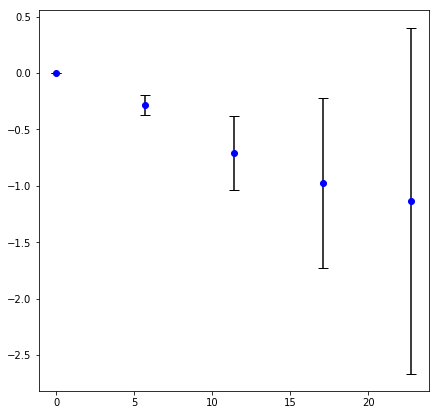

In [29]:
plt.figure(figsize=(7,7))
plt.errorbar(blen, np.log(cor_n6[0]), yerr=mk, color='b', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')

In [30]:
# From fitting all points, I get best fit 
from sklearn.linear_model import LinearRegression
model_n6 = LinearRegression(fit_intercept=False)
model_n6.fit(blen.reshape(-1,1), n6lc)
# Slope here is in nanometers
print("Model slope:    ", model_n6.coef_)
print("Model intercept:", model_n6.intercept_)

Model slope:     [-0.05357403]
Model intercept: 0.0


In [31]:
gg = model_n6.predict(blen.reshape(-1,1))
gg

array([ 0.        , -0.30493786, -0.60987572, -0.91481358, -1.21975144])

In [32]:
print("Mean Std Error:", sklearn.metrics.mean_squared_error(n6lc, gg))
print("R2 score:", sklearn.metrics.r2_score(n6lc, gg))

Mean Std Error: 0.004365021733667115
R2 score: 0.9755140507889415


In [33]:
# Residuals between the true y data and model y data 
resid_n6 = n6lc - gg
resid_n6

array([ 0.        ,  0.021091  , -0.10085324, -0.05794131,  0.08860985])

In [34]:
# How to calculate mean squared error
np.sum(resid_n6**2)/len(resid_n6)

0.004365021733667115

In [35]:
# Standard error: Square root of the mean squared error 
np.sqrt(np.sum(resid_n6**2)/len(resid_n6))

0.06606831111559547

In [36]:
# population variance of the residuals 
var_n6p = np.var(resid_n6)
var_n6p

0.004268614085390064

In [37]:
# Sample variance: https://www.statisticshowto.datasciencecentral.com/
# probability-and-statistics/descriptive-statistics/sample-variance/

# sample variance of the residuals 
ntres = resid_n6
ntres -= np.mean(resid_n6)
nhres = ntres**2
np.sum(nhres)/4

0.00533576760673758

In [38]:
# How to calculate Sum((Xi - avg(X))^2): X values are the bond length values 
nt_tt = np.arange(5, dtype=float)
nt_tt *= lb_avg
nt_tt -= np.mean(nt_tt)
nhui = nt_tt**2
np.sum(nhui)

323.9769653584891

In [ ]:
# How to calculate Sum((Xi - avg(X))^2), alternate version, Bond Length X values 
nt_tt = np.arange(5, dtype=float)
nt_tt *= lb_avg
np.sum(nt_tt**2) - ((np.sum(nt_tt)**2)/5)

In [ ]:
# t-value with 95 % confidence intervals 
scipy.stats.t.ppf(0.975, 4)

In [39]:
# How to calculate 95% confidence interval for the slope 
flc_n6 = scipy.stats.t.ppf(0.975, 4)*np.sqrt((np.sum(resid_n6**2)/len(resid_n6))/(np.sum(nhui)))
flc_n6

0.010078025924297108

In [40]:
pers_n6 =-1/model_n6.coef_
pers_n6

array([18.6657618])

In [41]:
# Pers length error: error propagation from uncertainty in slope 
flc_n6/((model_n6.coef_)**2)

array([3.5112917])

In [42]:
blen

array([ 0.        ,  5.69189745, 11.38379489, 17.07569234, 22.76758978])

Text(5, -0.15, 'R$^{2}$ = 0.98')

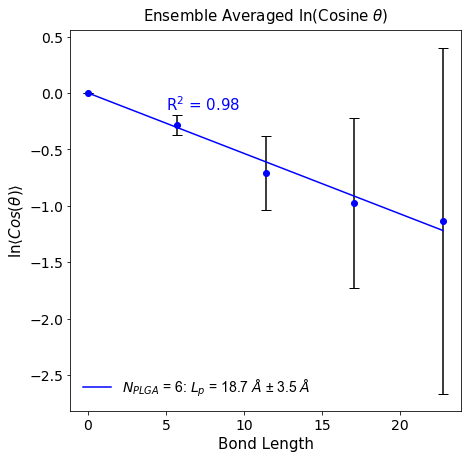

In [43]:
plt.figure(figsize=(7,7))
plt.errorbar(blen, np.log(cor_n6[0]), yerr=mk, color='b', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.plot(blen, gg, color='b')
plt.title(r'Ensemble Averaged ln(Cosine $\theta$)', fontsize=15, y=1.01)
plt.xlabel(r'Bond Length', fontsize=15)
plt.ylabel(r'ln$\left< Cos(\theta)\right >$', fontsize=15)
#plt.ylim(-1.9,0)
font = font_manager.FontProperties(family='Arial', style='normal', size='14')
plt.legend([r'$N_{PLGA}$ = 6: $L_{p}$ = 18.7 $\AA$ ± 3.5 $\AA$'], loc=3, frameon=0, fontsize=14, prop=font)
plt.tick_params(labelsize=14)
plt.text(5,-0.15,r'R$^{2}$ = 0.98', fontsize=15, color='blue')

In [ ]:
lb_avg

In [ ]:
exfun(nt, pers_n6)

In [ ]:
def exfun(x, a):
    return np.exp(-x*lb_avg/a)
nt = np.arange(5)
#nt += 1
plt.scatter(nt, cor_n6[0])
# a-axis is the number of bond lengths away 
plt.plot(nt,exfun(nt, pers_n6))
plt.ylim(0,1.2)

## N = 8 water

In [44]:
n8_plga_wat = mda.Universe("n8_plga_50ns/0_xa_soln/confout.gro", "n8_plga_50ns/0_xa_soln/nopbc_traj.xtc")

In [45]:
n8_plga_wat

<Universe with 12609 atoms>

In [46]:
#Select the polymer heavy atoms 
poly_n8 = n8_plga_wat.select_atoms("resname sPLG PLG tPLG and not type H")

In [47]:
len(n8_plga_wat.trajectory)

5001

In [48]:
com_bond_n8 = np.zeros(shape=(1,5000))
count = 0
for ts in n8_plga_wat.trajectory[0:5000]:
    n8_mon1 = n8_plga_wat.select_atoms("resid 1")
    n8_mon2 = n8_plga_wat.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n8_mon1.center_of_mass(), n8_mon2.center_of_mass(), 
                                                   box=n8_plga_wat.trajectory.ts.dimensions)
    com_bond_n8[0, count] = oo_len
    count += 1
lb_avg_n8 = np.mean(com_bond_n8)
lb_avg_n8

5.419908626450464

In [ ]:
plt.scatter(np.arange(5000),com_bond_n8)
plt.scatter(np.arange(5000),com_bond)

In [49]:
lb_avg_n8

5.419908626450464

In [50]:
lb_avg

5.691897446005937

In [ ]:
n8_blks = bavg_pers_cnt(5, poly_n8, n8_plga_wat, lb_avg, 0 , 5000)

In [ ]:
n8_blks["Avg persistence length"]

In [ ]:
n8_blks["Avg Radius of gyration"]

In [51]:
n8_rgens, cor_n8_mat, N8ens_cos, rg_avgn8 = get_rg_pers_poly(poly_n8, n8_plga_wat, 0, 5000, lb_avg)

In [52]:
cor_n8_mat

array([[1.00000000e+00, 7.83997871e-01, 5.26026861e-01, 3.72849503e-01,
        2.77911770e-01, 2.30961802e-01, 2.70035833e-01],
       [4.12429549e-17, 4.87656382e-02, 1.14853285e-01, 1.94616388e-01,
        2.93427907e-01, 4.09681649e-01, 5.30065773e-01],
       [0.00000000e+00, 3.81441306e+01, 5.79099027e+01, 6.75021816e+01,
        7.28586935e+01, 7.52401371e+01, 7.19311438e+01],
       [1.00000000e+00, 2.00000000e+00, 3.00000000e+00, 4.00000000e+00,
        5.00000000e+00, 6.00000000e+00, 7.00000000e+00]])

In [53]:
cor_n8_mat[0]

array([1.        , 0.78399787, 0.52602686, 0.3728495 , 0.27791177,
       0.2309618 , 0.27003583])

In [54]:
cor_n8_mat[1]

array([4.12429549e-17, 4.87656382e-02, 1.14853285e-01, 1.94616388e-01,
       2.93427907e-01, 4.09681649e-01, 5.30065773e-01])

In [55]:
# error prop into natural log values 
mk_n8 = cor_n8_mat[1]/cor_n8_mat[0]
#mk_n8 /= 2
mk_n8

array([4.12429549e-17, 6.22012380e-02, 2.18341102e-01, 5.21970357e-01,
       1.05583116e+00, 1.77380695e+00, 1.96294605e+00])

In [56]:
cor_n8_mat[1]/cor_n8_mat[0]

array([4.12429549e-17, 6.22012380e-02, 2.18341102e-01, 5.21970357e-01,
       1.05583116e+00, 1.77380695e+00, 1.96294605e+00])

In [57]:
# For some reason, fit does not work if lb_avg is in angstroms
lb_avg = np.mean(com_bond)
#lb_avg /= 10
lb_avg

5.691897446005937

In [58]:
# x values
nt_ttn8 = np.arange(7, dtype=float)
nt_ttn8 *= lb_avg
#nt_ttn8[0] = 0
nt_ttn8

array([ 0.        ,  5.69189745, 11.38379489, 17.07569234, 22.76758978,
       28.45948723, 34.15138468])

In [59]:
# Sample standard deviation of Bond Length x values 
np.sqrt((np.sum(nt_ttn8**2) - ((np.sum(nt_ttn8)**2)/7))/6)

12.29590380983148

In [60]:
# Sample variance of Bond Length x values 
n8svar = (np.sum(nt_ttn8**2) - ((np.sum(nt_ttn8)**2)/7))/6
n8svar

151.18925050062828

In [61]:
# y values
n8lc = np.log(cor_n8_mat[0])
n8lc

array([ 0.        , -0.24334897, -0.642403  , -0.98658042, -1.28045159,
       -1.46550294, -1.30920061])

In [ ]:
plt.figure(figsize=(7,7))
plt.errorbar(blen, np.log(cor_n6[0]), yerr=mk, color='b', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')

In [62]:
from sklearn.linear_model import LinearRegression
model_n8 = LinearRegression(fit_intercept=False)
model_n8.fit(nt_ttn8[:5].reshape(-1,1), n8lc[:5])
# Slope here is in nanometers
print("Model slope:    ", model_n8.coef_)
print("Model intercept:", model_n8.intercept_)

Model slope:     [-0.05627709]
Model intercept: 0.0


In [63]:
gg_n8 = model_n8.predict(nt_ttn8.reshape(-1,1))
gg_n8

array([ 0.        , -0.32032342, -0.64064684, -0.96097026, -1.28129368,
       -1.6016171 , -1.92194052])

In [64]:
print("Mean Std Error:", sklearn.metrics.mean_squared_error(n8lc[:5], gg_n8[:5]))
print("R2 score:", sklearn.metrics.r2_score(n8lc[:5], gg_n8[:5]))

Mean Std Error: 0.0013169477183577825
R2 score: 0.9939963442215671


In [65]:
# Residuals between the true y data and model y data 
resid_n8 = n8lc[:5] - gg_n8[:5]
resid_n8

array([ 0.        ,  0.07697444, -0.00175616, -0.02561016,  0.00084209])

In [66]:
# How to calculate mean squared error
np.sum(resid_n8**2)/len(resid_n8)

0.0013169477183577825

In [67]:
# Standard error: Square root of the mean squared error 
np.sqrt(np.sum(resid_n8**2)/len(resid_n8))

0.03628977429466574

In [68]:
# sample variance of the residuals 
ntres_n8 = resid_n8
ntres_n8 -= np.mean(resid_n8)
nhres_n8 = ntres_n8**2
np.sum(nhres_n8)/4

0.001518923448882437

In [69]:
# How to calculate Sum((Xi - avg(X))^2): X values are the bond length values 
nt_n8 = np.arange(5, dtype=float)
nt_n8 *= lb_avg
nt_n8 -= np.mean(nt_n8)
nhui = nt_n8**2
np.sum(nhui)

323.9769653584891

In [70]:
# How to calculate 95% confidence interval for the slope 
flc_n8 = scipy.stats.t.ppf(0.975, 6)*np.sqrt((np.sum(resid_n8**2)/len(resid_n8))/(np.sum(nhui)))
flc_n8

0.004738863444949515

In [71]:
pers_n8 =-1/model_n8.coef_
pers_n8

array([17.76922042])

In [72]:
# Pers length error: error propagation from uncertainty in slope 
flc_n8/((model_n8.coef_)**2)

array([1.49627336])

In [ ]:
nt_ttn8

In [ ]:
# ln(cos theta) error: error propagation from uncertainty in cos theta values 
mk_n8 = cor_n8_mat[1]/cor_n8_mat[0]
mk_n8

Text(5, -0.15, 'R$^{2}$ = 0.99')

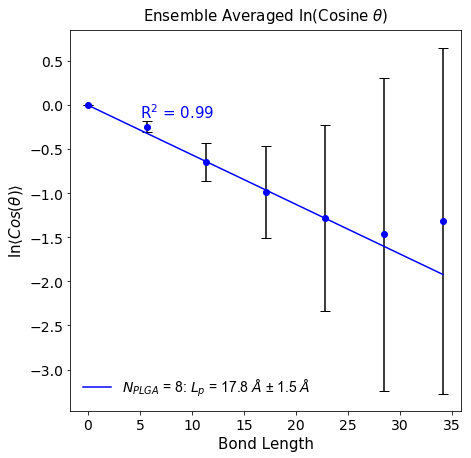

In [73]:
plt.figure(figsize=(7,7))
plt.errorbar(nt_ttn8, np.log(cor_n8_mat[0]), yerr=mk_n8, color='b', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.plot(nt_ttn8, gg_n8, color='b')
plt.title(r'Ensemble Averaged ln(Cosine $\theta$)', fontsize=15, y=1.01)
plt.xlabel(r'Bond Length', fontsize=15)
plt.ylabel(r'ln$\left< Cos(\theta)\right >$', fontsize=15)
#plt.ylim(-1.9,0)
font = font_manager.FontProperties(family='Arial', style='normal', size='14')
plt.legend([r'$N_{PLGA}$ = 8: $L_{p}$ = 17.8 $\AA$ ± 1.5 $\AA$'], loc=3, frameon=0, fontsize=14, prop=font)
plt.tick_params(labelsize=14)
plt.text(5,-0.15,r'R$^{2}$ = 0.99', fontsize=15, color='blue')

In [ ]:
def exfun(x, a):
    return np.exp(-x*lb_avg_n8/a)

nt = np.arange(7)
plt.scatter(nt, cor_n8_mat[0,:])
plt.plot(nt,exfun(nt, pers_n8))

## N = 10 water

In [74]:
n10_plga_wat = mda.Universe("n10_plga_50ns/0_xa_soln/N10_sys.gro", "n10_plga_50ns/0_xa_soln/nopbc_10wat.xtc")

In [75]:
n10_plga_wat

<Universe with 153 atoms>

In [76]:
len(n10_plga_wat.trajectory)

5001

In [77]:
poly_n10 = n10_plga_wat.select_atoms("resname sPLG PLG tPLG and not type H")

In [78]:
com_bond_n10 = np.zeros(shape=(1,5000))
count = 0
for ts in n10_plga_wat.trajectory[0:5000]:
    n10_mon1 = n10_plga_wat.select_atoms("resid 1")
    n10_mon2 = n10_plga_wat.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n10_mon1.center_of_mass(), n10_mon2.center_of_mass(), 
                                                   box=n10_plga_wat.trajectory.ts.dimensions)
    com_bond_n10[0, count] = oo_len
    count += 1
lb_avg_n10 = np.mean(com_bond_n10)

In [79]:
lb_avg_n10

5.591477567959724

In [ ]:
plt.scatter(np.arange(5000),com_bond)
plt.scatter(np.arange(5000),com_bond_n8)
plt.scatter(np.arange(5000),com_bond_n10)

In [80]:
lb_avg

5.691897446005937

In [ ]:
n10_blks = bavg_pers_cnt(5, poly_n10, n10_plga_wat, lb_avg_n10, 0 , 5000)

In [ ]:
# Extended Length of 10 monomer length plga: 6.436 nm 
n10_blks["Avg persistence length"]

In [ ]:
n10_blks["Avg Radius of gyration"]

In [ ]:
np.mean(n10_blks["Avg Radius of gyration"])

In [ ]:
np.std(n10_blks["Avg Radius of gyration"])

In [ ]:
np.mean(n10_blks["Avg persistence length"])

In [ ]:
np.std(n10_blks["Avg persistence length"])

In [81]:
n10_rgens, cor_n10_mat, N10ens_cos, rg_avgn10 = get_rg_pers_poly(poly_n10, n10_plga_wat, 0, 5000, lb_avg)

In [82]:
cor_n10_mat

array([[1.00000000e+00, 7.79108575e-01, 5.07420096e-01, 3.42634439e-01,
        1.84134505e-01, 1.88489795e-01, 2.29565788e-01, 2.14205164e-01,
        2.45898194e-01],
       [4.29413829e-17, 3.77019867e-02, 9.48600308e-02, 1.46611385e-01,
        2.26419190e-01, 2.77070511e-01, 3.45257582e-01, 4.26962129e-01,
        5.25881515e-01],
       [0.00000000e+00, 3.86867496e+01, 5.92863723e+01, 6.96717699e+01,
        7.90602489e+01, 7.87134963e+01, 7.58420123e+01, 7.64257913e+01,
        7.35091173e+01],
       [1.00000000e+00, 2.00000000e+00, 3.00000000e+00, 4.00000000e+00,
        5.00000000e+00, 6.00000000e+00, 7.00000000e+00, 8.00000000e+00,
        9.00000000e+00]])

In [83]:
cor_n10_mat[0]

array([1.        , 0.77910858, 0.5074201 , 0.34263444, 0.18413451,
       0.18848979, 0.22956579, 0.21420516, 0.24589819])

In [84]:
cor_n10_mat[1]

array([4.29413829e-17, 3.77019867e-02, 9.48600308e-02, 1.46611385e-01,
       2.26419190e-01, 2.77070511e-01, 3.45257582e-01, 4.26962129e-01,
       5.25881515e-01])

In [85]:
mk_n10 = cor_n10_mat[1]/cor_n10_mat[0]
#mk_n10 /= 2
mk_n10

array([4.29413829e-17, 4.83911844e-02, 1.86945751e-01, 4.27894480e-01,
       1.22964020e+00, 1.46994967e+00, 1.50395922e+00, 1.99323920e+00,
       2.13861479e+00])

In [86]:
cor_n10_mat[1]/cor_n10_mat[0]

array([4.29413829e-17, 4.83911844e-02, 1.86945751e-01, 4.27894480e-01,
       1.22964020e+00, 1.46994967e+00, 1.50395922e+00, 1.99323920e+00,
       2.13861479e+00])

In [87]:
lb_avg = np.mean(com_bond)
#lb_avg /= 10
lb_avg

5.691897446005937

In [88]:
# x values
nt_ttn10 = np.arange(9, dtype=float)
nt_ttn10 *= lb_avg
#nt_ttn10[0] = 0
nt_ttn10

array([ 0.        ,  5.69189745, 11.38379489, 17.07569234, 22.76758978,
       28.45948723, 34.15138468, 39.84328212, 45.53517957])

In [89]:
# Sample standard deviation of Bond Length x values 
np.sqrt((np.sum(nt_ttn10**2) - ((np.sum(nt_ttn10)**2)/9))/8)

15.587903130917473

In [90]:
# Sample variance of Bond Length x values 
n10svar = (np.sum(nt_ttn10**2) - ((np.sum(nt_ttn10)**2)/9))/8
n10svar

242.98272401886675

In [91]:
# y values
n10lc = np.log(cor_n10_mat[0])
n10lc

array([ 0.        , -0.24960487, -0.67841603, -1.07109118, -1.69208878,
       -1.66871141, -1.47156563, -1.54082101, -1.40283767])

<ErrorbarContainer object of 3 artists>

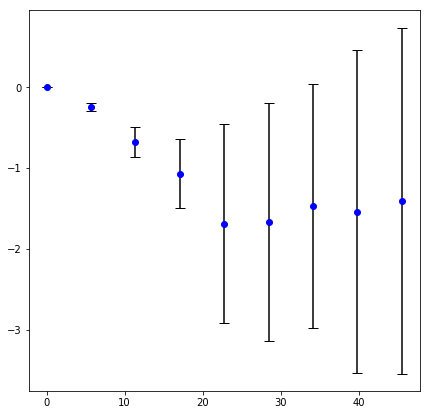

In [104]:
plt.figure(figsize=(7,7))
plt.errorbar(nt_ttn10, np.log(cor_n10_mat[0]), yerr=mk_n10, color='b', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')

In [105]:
nt_ttn10[:5]

array([ 0.        ,  5.69189745, 11.38379489, 17.07569234, 22.76758978])

In [112]:
from sklearn.linear_model import LinearRegression
model_n10 = LinearRegression(fit_intercept=False)
model_n10.fit(nt_ttn10[:5].reshape(-1,1), n10lc[:5])
# Slope here is in nanometers
print("Model slope:    ", model_n10.coef_)
print("Model intercept:", model_n10.intercept_)

Model slope:     [-0.06786293]
Model intercept: 0.0


In [113]:
gg_n10 = model_n10.predict(nt_ttn10.reshape(-1,1))
gg_n10

array([ 0.        , -0.38626885, -0.77253771, -1.15880656, -1.54507541,
       -1.93134426, -2.31761312, -2.70388197, -3.09015082])

In [114]:
print("Mean Std Error:", sklearn.metrics.mean_squared_error(n10lc[:5], model_n10.predict(nt_ttn10[:5].reshape(-1,1))))
print("R2 score:", sklearn.metrics.r2_score(n10lc[:5], model_n10.predict(nt_ttn10[:5].reshape(-1,1))))

Mean Std Error: 0.011368571031485463
R2 score: 0.9685596530931551


In [115]:
# Residuals between the true y data and model y data 
resid_n10 = n10lc[:5] - gg_n10[:5]
resid_n10

array([ 0.        ,  0.13666399,  0.09412168,  0.08771538, -0.14701337])

In [116]:
# How to calculate mean squared error
np.sum(resid_n10**2)/len(resid_n10)

0.011368571031485463

In [117]:
# Standard error: Square root of the mean squared error 
np.sqrt(np.sum(resid_n10**2)/len(resid_n10))

0.10662350130944614

In [118]:
# sample variance of the residuals 
ntres_n10 = resid_n10
ntres_n10 -= np.mean(resid_n10)
nhres_n10 = ntres_n10**2
np.sum(nhres_n10)/4

0.012740312660761702

In [119]:
# How to calculate Sum((Xi - avg(X))^2): X values are the bond length values 
nt_n10 = np.arange(5, dtype=float)
nt_n10 *= lb_avg
nt_n10 -= np.mean(nt_n10)
nhui = nt_n10**2
np.sum(nhui)

323.9769653584891

In [120]:
# How to calculate 95% confidence interval for the slope 
flc_n10 = scipy.stats.t.ppf(0.975, 4)*np.sqrt((np.sum(resid_n10**2)/len(resid_n10))/(np.sum(nhui)))
flc_n10

0.015572812735910331

In [121]:
pers_n10 =-1/model_n10.coef_
pers_n10

array([14.73558483])

In [122]:
# Pers length error: error propagation from uncertainty in slope 
flc_n10/((model_n10.coef_)**2)

array([3.38144101])

In [ ]:
mk_n10

In [ ]:
nt_ttn10

In [ ]:
np.log(cor_n10_mat[0])

Text(5, -0.15, 'R$^{2}$ = 0.97')

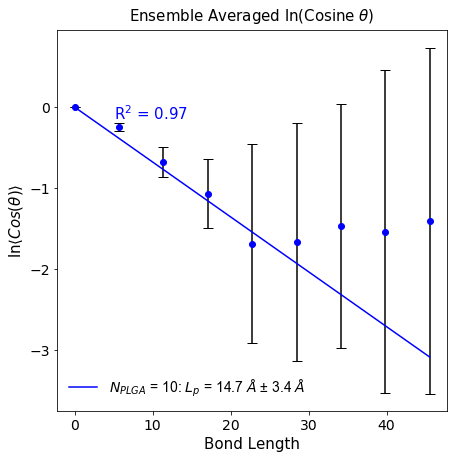

In [123]:
plt.figure(figsize=(7,7))
plt.errorbar(nt_ttn10, np.log(cor_n10_mat[0]), yerr=mk_n10, color='b', linestyle="None",marker='o', capsize=5, capthick=1, ecolor='black')
plt.plot(nt_ttn10, gg_n10, color='b')
plt.title(r'Ensemble Averaged ln(Cosine $\theta$)', fontsize=15, y=1.01)
plt.xlabel(r'Bond Length', fontsize=15)
plt.ylabel(r'ln$\left< Cos(\theta)\right >$', fontsize=15)
#plt.ylim(-1.9,0)
font = font_manager.FontProperties(family='Arial', style='normal', size='14')
plt.legend([r'$N_{PLGA}$ = 10: $L_{p}$ = 14.7 $\AA$ ± 3.4 $\AA$'], loc=3, frameon=0, fontsize=14, prop=font)
plt.tick_params(labelsize=14)
plt.text(5,-0.15,r'R$^{2}$ = 0.97', fontsize=15, color='blue')

In [ ]:
def exfun(x, a):
    return np.exp(-x*lb_avg/a)

nt = np.arange(9)
plt.scatter(nt, cor_n10_mat[0,:])
plt.plot(nt,exfun(nt, pers_n10))

## N = 20 water 

In [124]:
n20_plga_wat = mda.Universe("n20_plga_150ns/0_xa_soln/nowat_n20.gro", "n20_plga_150ns/0_xa_soln/N20_nopbcpp.xtc")

In [125]:
n20_plga_wat

<Universe with 303 atoms>

In [126]:
len(n20_plga_wat.trajectory)

15001

In [127]:
poly_n20 = n20_plga_wat.select_atoms("resname sPLG PLG tPLG and not type H")

In [128]:
com_bond_n20 = np.zeros(shape=(1,15000))
count = 0
for ts in n20_plga_wat.trajectory[0:15000]:
    n20_mon1 = n20_plga_wat.select_atoms("resid 1")
    n20_mon2 = n20_plga_wat.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n20_mon1.center_of_mass(), n20_mon2.center_of_mass(), 
                                                   box=n20_plga_wat.trajectory.ts.dimensions)
    com_bond_n20[0, count] = oo_len
    count += 1
lb_avg_n20 = np.mean(com_bond_n20)

In [129]:
lb_avg_n20

5.5775064834288015

In [ ]:
plt.scatter(np.arange(5000),com_bond)
plt.scatter(np.arange(5000),com_bond_n8)
plt.scatter(np.arange(5000),com_bond_n10)
plt.scatter(np.arange(15000),com_bond_n20)

In [ ]:
n20_blks = bavg_pers_cnt(5, poly_n20, n20_plga_wat, lb_avg, 0 , 15000)

In [ ]:
n20_blks["Avg persistence length"]

In [ ]:
n20_blks["Avg Radius of gyration"]

In [ ]:
np.mean(n20_blks["Avg Radius of gyration"])

In [ ]:
np.std(n20_blks["Avg Radius of gyration"])

In [ ]:
np.mean(n20_blks["Avg persistence length"])

In [ ]:
np.std(n20_blks["Avg persistence length"])

In [130]:
n20_rgens, cor_n20_mat, N20ens_cos, rg_avgn20 = get_rg_pers_poly(poly_n20, n20_plga_wat, 0, 15000, lb_avg)

In [131]:
cor_n20_mat

array([[1.00000000e+00, 8.04234473e-01, 5.55391937e-01, 4.10549867e-01,
        3.15349585e-01, 2.34350833e-01, 1.60106712e-01, 1.21574663e-01,
        1.29210061e-01, 1.53886197e-01, 1.86597215e-01, 2.14165630e-01,
        2.32049855e-01, 2.19609727e-01, 1.86049216e-01, 2.09226533e-01,
        2.86726315e-01, 2.96691967e-01, 2.73548450e-01],
       [2.45256282e-17, 2.44869261e-02, 5.38063524e-02, 7.03930952e-02,
        9.32741342e-02, 1.18628193e-01, 1.46359310e-01, 1.54003399e-01,
        1.41764306e-01, 1.41268670e-01, 1.64193349e-01, 2.05276514e-01,
        2.48272367e-01, 2.54296232e-01, 2.48675004e-01, 2.44574587e-01,
        3.52504655e-01, 4.08957456e-01, 5.20483096e-01],
       [0.00000000e+00, 3.63975452e+01, 5.61819429e+01, 6.56815419e+01,
        7.15160171e+01, 7.63261191e+01, 8.06564730e+01, 8.29040162e+01,
        8.24781541e+01, 8.10441779e+01, 7.90870717e+01, 7.73407705e+01,
        7.61293962e+01, 7.68242046e+01, 7.88574750e+01, 7.75528042e+01,
        7.22706194e+01

In [132]:
cor_n20_mat[0]

array([1.        , 0.80423447, 0.55539194, 0.41054987, 0.31534959,
       0.23435083, 0.16010671, 0.12157466, 0.12921006, 0.1538862 ,
       0.18659722, 0.21416563, 0.23204986, 0.21960973, 0.18604922,
       0.20922653, 0.28672631, 0.29669197, 0.27354845])

In [133]:
cor_n20_mat[1]

array([2.45256282e-17, 2.44869261e-02, 5.38063524e-02, 7.03930952e-02,
       9.32741342e-02, 1.18628193e-01, 1.46359310e-01, 1.54003399e-01,
       1.41764306e-01, 1.41268670e-01, 1.64193349e-01, 2.05276514e-01,
       2.48272367e-01, 2.54296232e-01, 2.48675004e-01, 2.44574587e-01,
       3.52504655e-01, 4.08957456e-01, 5.20483096e-01])

In [144]:
lb_avg = np.mean(com_bond)
#lb_avg /= 10
lb_avg

5.691897446005937

In [145]:
# x values
nt_ttn20 = np.arange(19, dtype=float)
nt_ttn20 *= lb_avg
#nt_ttn20[0] = 0
nt_ttn20

array([  0.        ,   5.69189745,  11.38379489,  17.07569234,
        22.76758978,  28.45948723,  34.15138468,  39.84328212,
        45.53517957,  51.22707701,  56.91897446,  62.61087191,
        68.30276935,  73.9946668 ,  79.68656424,  85.37846169,
        91.07035914,  96.76225658, 102.45415403])

In [146]:
# Sample standard deviation of Bond Length x values 
np.sqrt((np.sum(nt_ttn20**2) - ((np.sum(nt_ttn20)**2)/19))/18)

32.030096112383866

In [147]:
# Sample variance of Bond Length x values 
n20svar = (np.sum(nt_ttn20**2) - ((np.sum(nt_ttn20)**2)/19))/18
n20svar

1025.927056968548

In [148]:
# y values
n20lc = np.log(cor_n20_mat[0])
n20lc

array([ 0.        , -0.21786442, -0.58808122, -0.89025788, -1.15407346,
       -1.450936  , -1.83191474, -2.10722669, -2.04631582, -1.87154193,
       -1.67880291, -1.54100559, -1.46080304, -1.51590328, -1.68174404,
       -1.56433772, -1.24922713, -1.21506083, -1.29627653])

In [149]:
mk_n20 = cor_n20_mat[1]/cor_n20_mat[0]
mk_n20

array([2.45256282e-17, 3.04474963e-02, 9.68799667e-02, 1.71460524e-01,
       2.95780107e-01, 5.06199150e-01, 9.14136008e-01, 1.26673926e+00,
       1.09716151e+00, 9.18007417e-01, 8.79934615e-01, 9.58494201e-01,
       1.06990960e+00, 1.15794612e+00, 1.33660872e+00, 1.16894633e+00,
       1.22941159e+00, 1.37839073e+00, 1.90270900e+00])

<ErrorbarContainer object of 3 artists>

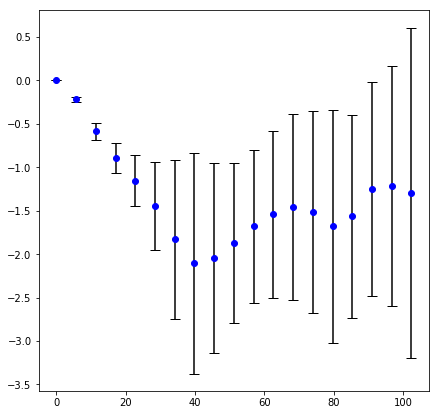

In [150]:
plt.figure(figsize=(7,7))
plt.errorbar(nt_ttn20, np.log(cor_n20_mat[0]), yerr=mk_n20, color='b', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')

In [151]:
nt_ttn20[:8]

array([ 0.        ,  5.69189745, 11.38379489, 17.07569234, 22.76758978,
       28.45948723, 34.15138468, 39.84328212])

In [152]:
from sklearn.linear_model import LinearRegression
model_n20 = LinearRegression(fit_intercept=False)
model_n20.fit(nt_ttn20[:8].reshape(-1,1), n20lc[:8])
# Slope here is in nanometers
print("Model slope:    ", model_n20.coef_)
print("Model intercept:", model_n20.intercept_)

Model slope:     [-0.05230223]
Model intercept: 0.0


In [153]:
gg_n20 = model_n20.predict(nt_ttn20.reshape(-1,1))
gg_n20

array([ 0.        , -0.29769893, -0.59539785, -0.89309678, -1.1907957 ,
       -1.48849463, -1.78619356, -2.08389248, -2.38159141, -2.67929033,
       -2.97698926, -3.27468818, -3.57238711, -3.87008604, -4.16778496,
       -4.46548389, -4.76318281, -5.06088174, -5.35858067])

In [154]:
print("Mean Std Error:", sklearn.metrics.mean_squared_error(n20lc[:8], model_n20.predict(nt_ttn20[:8].reshape(-1,1))))
print("R2 score:", sklearn.metrics.r2_score(n20lc[:8], model_n20.predict(nt_ttn20[:8].reshape(-1,1))))

Mean Std Error: 0.0014786533470702735
R2 score: 0.9969910523841001


In [155]:
# Residuals between the true y data and model y data 
resid_n20 = n20lc[:8] - gg_n20[:8]
resid_n20

array([ 0.        ,  0.07983451,  0.00731663,  0.0028389 ,  0.03672224,
        0.03755863, -0.04572118, -0.02333421])

In [156]:
# How to calculate mean squared error
np.sum(resid_n20**2)/len(resid_n20)

0.0014786533470702735

In [157]:
# Standard error: Square root of the mean squared error 
np.sqrt(np.sum(resid_n20**2)/len(resid_n20))

0.03845326185215337

In [158]:
# sample variance of the residuals 
ntres_n20 = resid_n20
ntres_n20 -= np.mean(resid_n20)
nhres_n20 = ntres_n20**2
np.sum(nhres_n20)/7

0.001527996791952926

In [159]:
# How to calculate Sum((Xi - avg(X))^2): X values are the bond length values 
nt_n20 = np.arange(8, dtype=float)
nt_n20 *= lb_avg
nt_n20 -= np.mean(nt_n20)
nhui = nt_n20**2
np.sum(nhui)

1360.703254505654

In [160]:
# How to calculate 95% confidence interval for the slope 
flc_n20 = scipy.stats.t.ppf(0.975, 4)*np.sqrt((np.sum(resid_n20**2)/len(resid_n20))/(np.sum(nhui)))
flc_n20

0.002752153337496418

In [161]:
pers_n20 =-1/model_n20.coef_
pers_n20

array([19.11964388])

In [162]:
# Pers length error: error propagation from uncertainty in slope 
flc_n20/((model_n20.coef_)**2)

array([1.00607933])

In [163]:
mk_n20 = cor_n20_mat[1]/cor_n20_mat[0]

Text(5, -0.15, 'R$^{2}$ = 0.99')

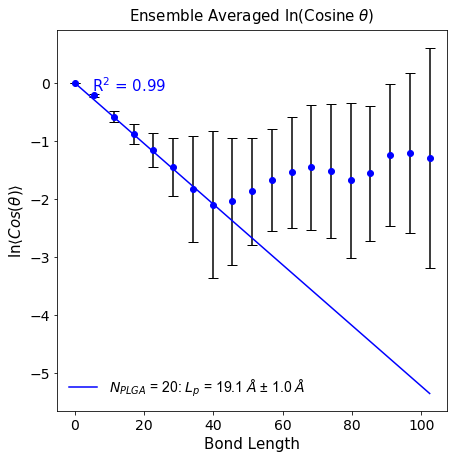

In [164]:
plt.figure(figsize=(7,7))
plt.errorbar(nt_ttn20, np.log(cor_n20_mat[0]), yerr=mk_n20, color='b', linestyle="None",marker='o',capsize=5, capthick=1, ecolor='black')
plt.plot(nt_ttn20, gg_n20, color='b')
plt.title(r'Ensemble Averaged ln(Cosine $\theta$)', fontsize=15, y=1.01)
plt.xlabel(r'Bond Length', fontsize=15)
plt.ylabel(r'ln$\left< Cos(\theta)\right >$', fontsize=15)
#plt.ylim(-1.9,0)
font = font_manager.FontProperties(family='Arial', style='normal', size='14')
plt.legend([r'$N_{PLGA}$ = 20: $L_{p}$ = 19.1 $\AA$ ± 1.0 $\AA$'], loc=3, frameon=0, fontsize=14, prop=font)
plt.tick_params(labelsize=14)
plt.text(5,-0.15,r'R$^{2}$ = 0.99', fontsize=15, color='blue')

In [ ]:
def exfun(x, a):
    return np.exp(-x*lb_avg/a)

nt = np.arange(19)
plt.scatter(nt, cor_n20_mat[0,:])
plt.plot(nt,exfun(nt, pers_n10))

## N= 30 water

In [134]:
n30_plga_wat = mda.Universe("n30_plga_150ns/0_xa_soln/0xa_n30sys.gro", "n30_plga_150ns/0_xa_soln/N30_nopbcpp_0xa.xtc")

In [135]:
n30_plga_wat

<Universe with 453 atoms>

In [136]:
len(n30_plga_wat.trajectory)

15001

In [137]:
poly_n30 = n30_plga_wat.select_atoms("resname sPLG PLG tPLG and not type H")

In [138]:
com_bond_n30 = np.zeros(shape=(1,15000))
count = 0
for ts in n30_plga_wat.trajectory[0:15000]:
    n30_mon1 = n30_plga_wat.select_atoms("resid 1")
    n30_mon2 = n30_plga_wat.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n30_mon1.center_of_mass(), n30_mon2.center_of_mass(), 
                                                   box=n30_plga_wat.trajectory.ts.dimensions)
    com_bond_n30[0, count] = oo_len
    count += 1
lb_avg_n30 = np.mean(com_bond_n30)

In [139]:
lb_avg_n30

5.60743077731889

In [140]:
lb_avg

5.691897446005937

In [ ]:
n30_blks = bavg_pers_cnt(5, poly_n30, n30_plga_wat, lb_avg, 0 , 15000)

In [ ]:
n30_blks["Avg persistence length"]

In [ ]:
n30_blks["Avg Radius of gyration"]

In [ ]:
np.mean(n30_blks["Avg persistence length"])

In [ ]:
np.std(n30_blks["Avg persistence length"])

In [141]:
n30_rgens, cor_n30_mat, N30ens_cos, rg_avgn30 = get_rg_pers_poly(poly_n30, n30_plga_wat, 0, 15000, lb_avg)

In [142]:
cor_n30_mat

array([[1.00000000e+00, 8.01626939e-01, 5.59763947e-01, 4.07940544e-01,
        2.88477954e-01, 2.06676644e-01, 1.97395011e-01, 2.09132854e-01,
        2.29247162e-01, 2.47037369e-01, 2.49057984e-01, 2.39151258e-01,
        2.24639612e-01, 1.91803437e-01, 1.55606314e-01, 1.17348345e-01,
        1.12893213e-01, 9.84067596e-02, 8.31411003e-02, 1.08596298e-01,
        1.75853043e-01, 2.51029805e-01, 2.75093507e-01, 2.78997503e-01,
        2.66341322e-01, 2.34591619e-01, 3.10879373e-01, 3.35070997e-01,
        3.44840391e-01],
       [3.73756764e-18, 2.43184433e-02, 4.61254110e-02, 5.22912909e-02,
        6.80569240e-02, 8.57331931e-02, 1.10237568e-01, 1.28808851e-01,
        1.26989345e-01, 9.38945667e-02, 8.42699253e-02, 1.15990201e-01,
        1.44349079e-01, 1.20882251e-01, 9.29037054e-02, 1.03798269e-01,
        1.20455451e-01, 1.38170232e-01, 1.36174814e-01, 1.41443088e-01,
        1.70993316e-01, 1.77569105e-01, 2.20845983e-01, 2.18563295e-01,
        1.98549866e-01, 2.22688080e-01,

In [143]:
cor_n30_mat[0]

array([1.        , 0.80162694, 0.55976395, 0.40794054, 0.28847795,
       0.20667664, 0.19739501, 0.20913285, 0.22924716, 0.24703737,
       0.24905798, 0.23915126, 0.22463961, 0.19180344, 0.15560631,
       0.11734835, 0.11289321, 0.09840676, 0.0831411 , 0.1085963 ,
       0.17585304, 0.2510298 , 0.27509351, 0.2789975 , 0.26634132,
       0.23459162, 0.31087937, 0.335071  , 0.34484039])

In [165]:
# error propagation into natural log values 
mk_n30 = cor_n30_mat[1]/cor_n30_mat[0]

In [166]:
# For some reason, fit does not work if lb_avg is in angstroms
lb_avg = np.mean(com_bond)
#lb_avg /= 10
lb_avg

5.691897446005937

In [167]:
# x values
nt_ttn30 = np.arange(29, dtype=float)
nt_ttn30 *= lb_avg
#nt_ttn10[0] = 0
nt_ttn30

array([  0.        ,   5.69189745,  11.38379489,  17.07569234,
        22.76758978,  28.45948723,  34.15138468,  39.84328212,
        45.53517957,  51.22707701,  56.91897446,  62.61087191,
        68.30276935,  73.9946668 ,  79.68656424,  85.37846169,
        91.07035914,  96.76225658, 102.45415403, 108.14605147,
       113.83794892, 119.52984637, 125.22174381, 130.91364126,
       136.6055387 , 142.29743615, 147.9893336 , 153.68123104,
       159.37312849])

In [ ]:
nt_ttn30[:20]

In [168]:
# Sample standard deviation of Bond Length x values 
np.sqrt((np.sum(nt_ttn30**2) - ((np.sum(nt_ttn30)**2)/29))/28)

48.46476038163243

In [169]:
# Sample variance of Bond Length x values 
n30svar = (np.sum(nt_ttn30**2) - ((np.sum(nt_ttn30)**2)/29))/28
n30svar

2348.832998849048

In [170]:
# y values
n30lc = np.log(cor_n30_mat[0])
n30lc

array([ 0.        , -0.22111194, -0.58024011, -0.89663384, -1.24313661,
       -1.57659981, -1.62254843, -1.56478556, -1.47295455, -1.39821566,
       -1.39006954, -1.43065905, -1.49325789, -1.6512842 , -1.86042609,
       -2.14260846, -2.18131293, -2.31864578, -2.48721611, -2.22011796,
       -1.73810662, -1.3821836 , -1.29064421, -1.27655245, -1.32297663,
       -1.44990907, -1.16835031, -1.09341284, -1.0646736 ])

In [171]:
mk_n30

array([3.73756764e-18, 3.03363599e-02, 8.24015394e-02, 1.28183608e-01,
       2.35917244e-01, 4.14818005e-01, 5.58461775e-01, 6.15918772e-01,
       5.53940750e-01, 3.80082443e-01, 3.38354643e-01, 4.85007699e-01,
       6.42580700e-01, 6.30240275e-01, 5.97043290e-01, 8.84531169e-01,
       1.06698576e+00, 1.40407257e+00, 1.63787602e+00, 1.30246694e+00,
       9.72364844e-01, 7.07362637e-01, 8.02803327e-01, 7.83387995e-01,
       7.45471503e-01, 9.49258465e-01, 8.76974443e-01, 1.06902745e+00,
       1.44967138e+00])

<ErrorbarContainer object of 3 artists>

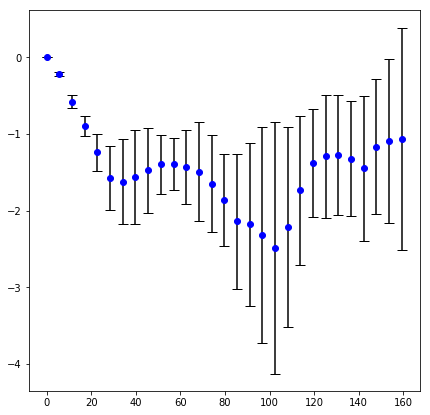

In [172]:
plt.figure(figsize=(7,7))
plt.errorbar(nt_ttn30, np.log(cor_n30_mat[0]), yerr=mk_n30, color='b', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')

In [ ]:
n30lc[:6]

In [174]:
nt_ttn30[:6]

array([ 0.        ,  5.69189745, 11.38379489, 17.07569234, 22.76758978,
       28.45948723])

In [175]:
from sklearn.linear_model import LinearRegression
model_n30 = LinearRegression(fit_intercept=False)
model_n30.fit(nt_ttn30[:6].reshape(-1,1), n30lc[:6])
# Slope here is in angstroms
print("Model slope:    ", model_n30.coef_)
print("Model intercept:", model_n30.intercept_)

Model slope:     [-0.05407061]
Model intercept: 0.0


In [176]:
gg_n30 = model_n30.predict(nt_ttn30.reshape(-1,1))
gg_n30

array([ 0.        , -0.30776435, -0.6155287 , -0.92329305, -1.2310574 ,
       -1.53882174, -1.84658609, -2.15435044, -2.46211479, -2.76987914,
       -3.07764349, -3.38540784, -3.69317219, -4.00093654, -4.30870088,
       -4.61646523, -4.92422958, -5.23199393, -5.53975828, -5.84752263,
       -6.15528698, -6.46305133, -6.77081567, -7.07858002, -7.38634437,
       -7.69410872, -8.00187307, -8.30963742, -8.61740177])

In [177]:
print("Mean Std Error:", sklearn.metrics.mean_squared_error(n30lc[:6], model_n30.predict(nt_ttn30[:6].reshape(-1,1))))
print("R2 score:", sklearn.metrics.r2_score(n30lc[:6], model_n30.predict(nt_ttn30[:6].reshape(-1,1))))

Mean Std Error: 0.0018396212067543895
R2 score: 0.9939317841425377


In [178]:
# Residuals between the true y data and model y data 
resid_n30 = n30lc[:6] - gg_n30[:6]
resid_n30

array([ 0.        ,  0.08665241,  0.03528859,  0.02665921, -0.01207922,
       -0.03777807])

In [179]:
# How to calculate mean squared error
np.sum(resid_n30**2)/len(resid_n30)

0.0018396212067543895

In [180]:
# Standard error: Square root of the mean squared error 
np.sqrt(np.sum(resid_n30**2)/len(resid_n30))

0.042890805620253734

In [181]:
# sample variance of the residuals 
ntres_n30 = resid_n30
ntres_n30 -= np.mean(resid_n30)
nhres_n30 = ntres_n30**2
# divide by n-1 samples
np.sum(nhres_n30)/5

0.0018825399842197308

In [182]:
# How to calculate Sum((Xi - avg(X))^2): X values are the bond length values 
nt_n30 = np.arange(6, dtype=float)
nt_n30 *= lb_avg
nt_n30 -= np.mean(nt_n30)
nhui = nt_n30**2
np.sum(nhui)

566.9596893773559

In [183]:
# How to calculate 95% confidence interval for the slope 
flc_n30 = scipy.stats.t.ppf(0.975, 4)*np.sqrt((np.sum(resid_n30**2)/len(resid_n30))/(np.sum(nhui)))
flc_n30

0.004618431236690752

In [184]:
pers_n30 =-1/model_n30.coef_
pers_n30

array([18.49433655])

In [185]:
# Pers length error: error propagation from uncertainty in slope 
flc_n30/((model_n30.coef_)**2)

array([1.57969046])

In [198]:
mk_n30 = cor_n30_mat[1]/cor_n30_mat[0]

In [203]:
def slope_plen(x,m):
    return m*x


In [204]:
ttsam = np.arange(12, dtype=float)
ttsam *= lb_avg
#nt_ttn10[0] = 0
ttsam

array([ 0.        ,  5.69189745, 11.38379489, 17.07569234, 22.76758978,
       28.45948723, 34.15138468, 39.84328212, 45.53517957, 51.22707701,
       56.91897446, 62.61087191])

In [ ]:
model_n10.coef_[0]

In [ ]:
slope_plen(ttsam, model_n10.coef_[0])

In [195]:
blen

array([ 0.        ,  5.69189745, 11.38379489, 17.07569234, 22.76758978])

In [196]:
np.log(cor_n6[0])

array([ 0.        , -0.28384686, -0.71072896, -0.97275489, -1.13114158])

In [197]:
mk

array([3.73756764e-18, 3.03363599e-02, 8.24015394e-02, 1.28183608e-01,
       2.35917244e-01, 4.14818005e-01, 5.58461775e-01, 6.15918772e-01,
       5.53940750e-01, 3.80082443e-01, 3.38354643e-01, 4.85007699e-01,
       6.42580700e-01, 6.30240275e-01, 5.97043290e-01, 8.84531169e-01,
       1.06698576e+00, 1.40407257e+00, 1.63787602e+00, 1.30246694e+00,
       9.72364844e-01, 7.07362637e-01, 8.02803327e-01, 7.83387995e-01,
       7.45471503e-01, 9.49258465e-01, 8.76974443e-01, 1.06902745e+00,
       1.44967138e+00])

Text(1, -4.7, '$N_{PLGA}$ = 6: $L_{p}$ = 18.7 $\\AA$ ± 3.5 $\\AA$, R$^{2}$ = 0.98')

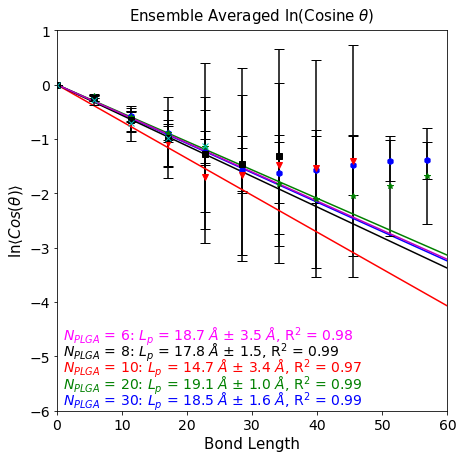

In [218]:
plt.figure(figsize=(7,7))
plt.errorbar(nt_ttn30, np.log(cor_n30_mat[0]), yerr=mk_n30, color='b', linestyle="None",marker='h',
     capsize=5, capthick=1, ecolor='black')
plt.plot(ttsam, slope_plen(ttsam, model_n30.coef_[0]), color='b')
plt.errorbar(nt_ttn20, np.log(cor_n20_mat[0]), yerr=mk_n20, color='g', linestyle="None"
             ,marker='*',capsize=5, capthick=1, ecolor='black')
plt.plot(ttsam, slope_plen(ttsam, model_n20.coef_[0]), color='g')
plt.errorbar(nt_ttn10, np.log(cor_n10_mat[0]), yerr=mk_n10, color='r', linestyle="None"
             ,marker='v', capsize=5, capthick=1, ecolor='black')
plt.plot(ttsam, slope_plen(ttsam, model_n10.coef_[0]), color='r')
plt.errorbar(nt_ttn8, np.log(cor_n8_mat[0]), yerr=mk_n8, color='k', linestyle="None",marker='s'
             ,capsize=5, capthick=1, ecolor='black')
plt.plot(ttsam, slope_plen(ttsam, model_n8.coef_[0]), color='k')
plt.errorbar(blen, np.log(cor_n6[0]), yerr=mk, color='c', linestyle="None",marker='x'
             ,capsize=5, capthick=1, ecolor='black')
plt.plot(ttsam, slope_plen(ttsam, model_n6.coef_[0]), color='m')
plt.title(r'Ensemble Averaged ln(Cosine $\theta$)', fontsize=15, y=1.01)
plt.xlabel(r'Bond Length', fontsize=15)
plt.ylabel(r'ln$\left< Cos(\theta)\right >$', fontsize=15)
plt.ylim(-6, 1)
plt.xlim(0,60)
font = font_manager.FontProperties(family='Arial', style='normal', size='14')
#plt.legend([r'$N_{PLGA}$ = 30: $L_{p}$ = 18.5 $\AA$ ± 0.15 $\AA$,  R$^{2}$ = 0.99', 
#r'$N_{PLGA}$ = 20: $L_{p}$ = 19.1 $\AA$ ± 0.27 $\AA$,  R$^{2}$ = 0.99'], 
#           loc=3, frameon=0, fontsize=14, prop=font)
#plt.legend([r'$N_{PLGA}$ = 20: $L_{p}$ = 19.1 $\AA$ ± 0.27 $\AA$,  R$^{2}$ = 0.99'], 
#loc=3, frameon=0, fontsize=14, prop=font)
plt.tick_params(labelsize=14)
plt.text(1, -5.9,r'$N_{PLGA}$ = 30: $L_{p}$ = 18.5 $\AA$ ± 1.6 $\AA$, R$^{2}$ = 0.99', fontsize=14, color='blue')
plt.text(1,-5.6,r'$N_{PLGA}$ = 20: $L_{p}$ = 19.1 $\AA$ ± 1.0 $\AA$, R$^{2}$ = 0.99', fontsize=14, color='green')
plt.text(1,-5.3,r'$N_{PLGA}$ = 10: $L_{p}$ = 14.7 $\AA$ ± 3.4 $\AA$, R$^{2}$ = 0.97', fontsize=14, color='red')
plt.text(1,-5.0,r'$N_{PLGA}$ = 8: $L_{p}$ = 17.8 $\AA$ ± 1.5, R$^{2}$ = 0.99', fontsize=14, color='black')
plt.text(1,-4.7,r'$N_{PLGA}$ = 6: $L_{p}$ = 18.7 $\AA$ ± 3.5 $\AA$, R$^{2}$ = 0.98', fontsize=14, color='magenta')
#plt.text(2.5,0,r'R$^{2}$ = 0.96', fontsize=15, color='red')

In [ ]:
cor_n8_mat[0]

In [ ]:
nt_ttn8

In [ ]:
def exfun(x, a):
    return np.exp(-x*lb_avg/a)

nt = np.arange(29)
plt.scatter(nt, cor_n30_mat[0,:])
plt.plot(nt,exfun(nt, pers_n30))

### Acetone systems only

## N = 6 acetone

In [219]:
n6_plga_ace = mda.Universe("n6_plga_50ns/1_xa_soln/confout.gro", "n6_plga_50ns/1_xa_soln/nopbc_n6ace.xtc")

In [220]:
n6_plga_ace

<Universe with 15093 atoms>

In [221]:
len(n6_plga_ace.trajectory)

5001

In [222]:
poly_n6_ace = n6_plga_ace.select_atoms("resname sPLG PLG tPLG and not type H")

In [223]:
com_bond_n6ace = np.zeros(shape=(1,5000))
count = 0
for ts in n6_plga_ace.trajectory[0:5000]:
    n6_mon1 = n6_plga_ace.select_atoms("resid 1")
    n6_mon2 = n6_plga_ace.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n6_mon1.center_of_mass(), n6_mon2.center_of_mass(), 
                                                   box=n6_plga_ace.trajectory.ts.dimensions)
    com_bond_n6ace[0, count] = oo_len
    count += 1
lb_avg_n6ace = np.mean(com_bond_n6ace)

In [224]:
lb_avg_n6ace

5.986551142328634

In [ ]:
plt.scatter(np.arange(5000),com_bond_n6ace)


In [ ]:
n6_blks_ace = bavg_pers_cnt(5, poly_n6_ace, n6_plga_ace, lb_avg_n6ace, 0 , 5000)

In [ ]:
n6_blks_ace["Avg persistence length"]

In [ ]:
n6_blks_ace["Avg Radius of gyration"]

In [ ]:
np.mean(n6_blks_ace["Avg persistence length"])

In [ ]:
np.std(n6_blks_ace["Avg persistence length"])

In [ ]:
np.mean(n6_blks_ace["Avg Radius of gyration"])

In [ ]:
np.std(n6_blks_ace["Avg Radius of gyration"])

In [225]:
n6_rgensace, cor_n6ace_mat, N30ens_cos, rg_avgn6ace = get_rg_pers_poly(poly_n6_ace, n6_plga_ace, 0, 5000, 
                                                                       lb_avg_n6ace)

In [226]:
cor_n6ace_mat

array([[1.00000000e+00, 8.88038846e-01, 7.66680371e-01, 6.63795607e-01,
        5.42956412e-01],
       [5.99109098e-17, 5.29430335e-02, 1.39636357e-01, 2.37859458e-01,
        4.20602666e-01],
       [0.00000000e+00, 2.65847839e+01, 3.82313714e+01, 4.56592788e+01,
        5.23508193e+01],
       [1.00000000e+00, 2.00000000e+00, 3.00000000e+00, 4.00000000e+00,
        5.00000000e+00]])

In [227]:
cor_n6ace_mat[0]

array([1.        , 0.88803885, 0.76668037, 0.66379561, 0.54295641])

In [228]:
# x values
ace_ttn6 = np.arange(5, dtype=float)
ace_ttn6 *= lb_avg_n6ace
#nt_ttn20[0] = 0
ace_ttn6

array([ 0.        ,  5.98655114, 11.97310228, 17.95965343, 23.94620457])

In [229]:
# Sample standard deviation of Bond Length x values 
np.sqrt((np.sum(ace_ttn6**2) - ((np.sum(ace_ttn6)**2)/5))/4)

9.465568469420667

In [230]:
# Sample variance of Bond Length x values 
n6sace_var = (np.sum(ace_ttn6**2) - ((np.sum(ace_ttn6)**2)/5))/4
n6sace_var

89.59698644929071

In [231]:
# y values
n6lc_ace = np.log(cor_n6ace_mat[0])
n6lc_ace

array([ 0.        , -0.11873979, -0.26568529, -0.409781  , -0.61072623])

In [232]:
mk_n6ace = cor_n6ace_mat[1]/cor_n6ace_mat[0]

<ErrorbarContainer object of 3 artists>

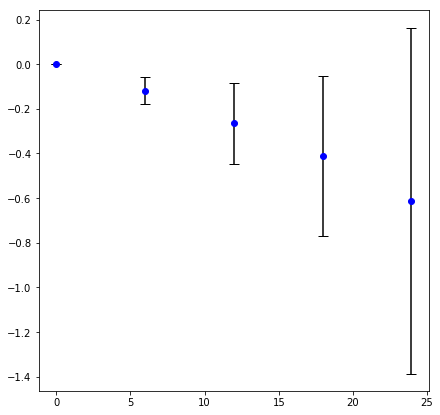

In [233]:
plt.figure(figsize=(7,7))
plt.errorbar(ace_ttn6, np.log(cor_n6ace_mat[0]), yerr=mk_n6ace, color='b', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')

In [234]:
from sklearn.linear_model import LinearRegression
model_n6ace = LinearRegression(fit_intercept=False)
model_n6ace.fit(ace_ttn6.reshape(-1,1), n6lc_ace)
# Slope here is in angstroms
print("Model slope:    ", model_n6ace.coef_)
print("Model intercept:", model_n6ace.intercept_)

Model slope:     [-0.02406705]
Model intercept: 0.0


In [235]:
gg_n6ace = model_n6ace.predict(ace_ttn6.reshape(-1,1))
gg_n6ace

array([ 0.        , -0.14407861, -0.28815722, -0.43223583, -0.57631444])

In [236]:
print("Mean Std Error:", sklearn.metrics.mean_squared_error(n6lc_ace, model_n6ace.predict(ace_ttn6.reshape(-1,1))))
print("R2 score:", sklearn.metrics.r2_score(n6lc_ace, model_n6ace.predict(ace_ttn6.reshape(-1,1))))

Mean Std Error: 0.0005670868965599438
R2 score: 0.9877162375147319


In [237]:
# Residuals between the true y data and model y data 
resid_n6ace = n6lc_ace - gg_n6ace
resid_n6ace

array([ 0.        ,  0.02533882,  0.02247193,  0.02245483, -0.03441179])

In [238]:
# How to calculate mean squared error
np.sum(resid_n6ace**2)/len(resid_n6ace)

0.0005670868965599438

In [239]:
# Standard error: Square root of the mean squared error 
np.sqrt(np.sum(resid_n6ace**2)/len(resid_n6ace))

0.023813586385925657

In [240]:
# sample variance of the residuals 
ntr_n6ace = resid_n6ace
ntr_n6ace -= np.mean(resid_n6ace)
nhr_n6ace = ntr_n6ace**2
np.sum(nhr_n6ace)/4

0.0006445839181727181

In [241]:
# How to calculate Sum((Xi - avg(X))^2): X values are the bond length values 
nt_n6ace = np.arange(5, dtype=float)
nt_n6ace *= lb_avg_n6ace
nt_n6ace -= np.mean(nt_n6ace)
nhui = nt_n6ace**2
np.sum(nhui)

358.38794579716273

In [242]:
# How to calculate 95% confidence interval for the slope 
flc_n6ace = scipy.stats.t.ppf(0.975, 4)*np.sqrt((np.sum(resid_n6ace**2)/len(resid_n6ace))/(np.sum(nhui)))
flc_n6ace

0.003330405543164769

In [243]:
pers_n6ace =-1/model_n6ace.coef_
pers_n6ace

array([41.55058921])

In [244]:
# Pers length error: error propagation from uncertainty in slope 
flc_n6ace/((model_n6ace.coef_)**2)

array([5.74978352])

In [245]:
def slope_plen(x,m):
    return m*x

ttsam = np.arange(5, dtype=float)
ttsam *= lb_avg_n6ace
#nt_ttn10[0] = 0
ttsam

array([ 0.        ,  5.98655114, 11.97310228, 17.95965343, 23.94620457])

Text(5, 0, 'R$^{2}$ = 0.99')

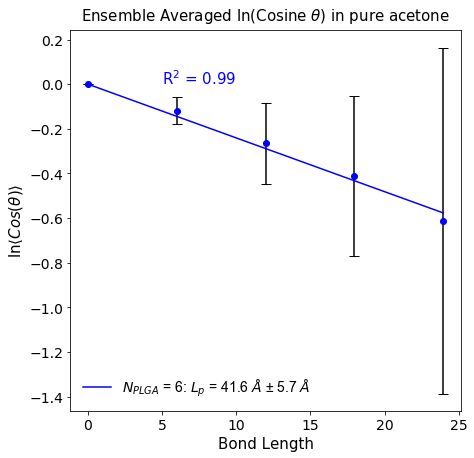

In [246]:
plt.figure(figsize=(7,7))
plt.errorbar(ace_ttn6, np.log(cor_n6ace_mat[0]), yerr=mk_n6ace, color='b', linestyle="None",marker='o',capsize=5, capthick=1, ecolor='black')
plt.plot(ttsam, slope_plen(ttsam, model_n6ace.coef_[0]), color='b')
plt.title(r'Ensemble Averaged ln(Cosine $\theta$) in pure acetone', fontsize=15, y=1.01)
plt.xlabel(r'Bond Length', fontsize=15)
plt.ylabel(r'ln$\left< Cos(\theta)\right >$', fontsize=15)
#plt.ylim(-1.9,0)
font = font_manager.FontProperties(family='Arial', style='normal', size='14')
plt.legend([r'$N_{PLGA}$ = 6: $L_{p}$ = 41.6 $\AA$ ± 5.7 $\AA$'], loc=3, frameon=0, fontsize=14, prop=font)
plt.tick_params(labelsize=14)
plt.text(5,0,r'R$^{2}$ = 0.99', fontsize=15, color='blue')

In [ ]:
def exfun(x, a):
    return np.exp(-x*lb_avg_n6ace/a)

nt = np.arange(5)
plt.scatter(nt, cor_n6ace_mat[0,:])
plt.plot(nt,exfun(nt, pers_n6ace))

## N = 8 acetone

In [247]:
n8_plga_ace = mda.Universe("n8_plga_50ns/1_xa_soln/confout.gro", "n8_plga_50ns/1_xa_soln/nopbc_n8ace.xtc")

In [248]:
n8_plga_ace

<Universe with 15123 atoms>

In [249]:
len(n8_plga_ace.trajectory)

5001

In [250]:
poly_n8_ace = n8_plga_ace.select_atoms("resname sPLG PLG tPLG and not type H")

In [251]:
com_bond_n8ace = np.zeros(shape=(1,5000))
count = 0
for ts in n8_plga_ace.trajectory[0:5000]:
    n8_mon1 = n8_plga_ace.select_atoms("resid 1")
    n8_mon2 = n8_plga_ace.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n8_mon1.center_of_mass(), n8_mon2.center_of_mass(), 
                                                   box=n8_plga_ace.trajectory.ts.dimensions)
    com_bond_n8ace[0, count] = oo_len
    count += 1
lb_avg_n8ace = np.mean(com_bond_n8ace)

In [252]:
lb_avg_n8ace

6.136198777572896

In [ ]:
plt.scatter(np.arange(5000),com_bond_n6ace)
plt.scatter(np.arange(5000),com_bond_n8ace)

In [ ]:
n8_blks_ace = bavg_pers_cnt(5, poly_n8_ace, n8_plga_ace, lb_avg_n6ace, 0 , 5000)

In [ ]:
n8_blks_ace["Avg persistence length"]

In [ ]:
n8_blks_ace["Avg Radius of gyration"]

In [ ]:
np.mean(n8_blks_ace["Avg persistence length"])

In [ ]:
np.std(n8_blks_ace["Avg persistence length"])

In [ ]:
np.mean(n8_blks_ace["Avg Radius of gyration"])

In [ ]:
np.std(n8_blks_ace["Avg Radius of gyration"])

In [253]:
n8_rgens_ace, cor_n8ace_mat, N8aceens_cos, rg_avgn8ace = get_rg_pers_poly(poly_n8_ace, n8_plga_ace, 0, 5000, 
                                                                        lb_avg_n6ace)

In [254]:
cor_n8ace_mat

array([[1.00000000e+00, 8.98773600e-01, 7.87905962e-01, 6.78127276e-01,
        5.54768195e-01, 4.51066218e-01, 3.81645046e-01],
       [3.94090079e-17, 4.20953677e-02, 1.07763247e-01, 2.09057403e-01,
        3.31944881e-01, 4.83925116e-01, 5.91025295e-01],
       [0.00000000e+00, 2.54425992e+01, 3.67670941e+01, 4.50727437e+01,
        5.33046990e+01, 5.94938387e+01, 6.34987022e+01],
       [1.00000000e+00, 2.00000000e+00, 3.00000000e+00, 4.00000000e+00,
        5.00000000e+00, 6.00000000e+00, 7.00000000e+00]])

In [255]:
cor_n8ace_mat[0]

array([1.        , 0.8987736 , 0.78790596, 0.67812728, 0.55476819,
       0.45106622, 0.38164505])

In [256]:
# x values
ace_ttn8 = np.arange(7, dtype=float)
ace_ttn8 *= lb_avg_n6ace
#nt_ttn20[0] = 0
ace_ttn8

array([ 0.        ,  5.98655114, 11.97310228, 17.95965343, 23.94620457,
       29.93275571, 35.91930685])

In [257]:
# Sample standard deviation of Bond Length x values 
np.sqrt((np.sum(ace_ttn8**2) - ((np.sum(ace_ttn8)**2)/7))/6)

12.932428543729753

In [258]:
# Sample variance of Bond Length x values 
n8sace_var = (np.sum(ace_ttn8**2) - ((np.sum(ace_ttn8)**2)/7))/6
n8sace_var

167.24770803867605

In [259]:
# y values
n8lc_ace = np.log(cor_n8ace_mat[0])
n8lc_ace

array([ 0.        , -0.10672411, -0.23837653, -0.38842029, -0.58920492,
       -0.79614113, -0.9632643 ])

In [260]:
mk_n8ace = cor_n8ace_mat[1]/cor_n8ace_mat[0]

<ErrorbarContainer object of 3 artists>

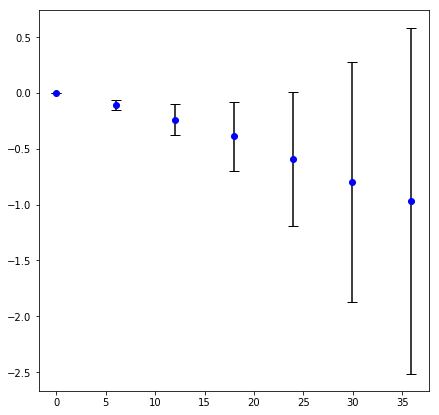

In [261]:
plt.figure(figsize=(7,7))
plt.errorbar(ace_ttn8, np.log(cor_n8ace_mat[0]), yerr=mk_n8ace, color='b', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')

In [ ]:
ace_ttn8[1:]

In [262]:
from sklearn.linear_model import LinearRegression
model_n8ace = LinearRegression(fit_intercept=False)
model_n8ace.fit(ace_ttn8.reshape(-1,1), n8lc_ace)
# Slope here is in angstroms
print("Model slope:    ", model_n8ace.coef_)
print("Model intercept:", model_n8ace.intercept_)

Model slope:     [-0.02545238]
Model intercept: 0.0


In [263]:
gg_n8ace = model_n8ace.predict(ace_ttn8.reshape(-1,1))
gg_n8ace

array([ 0.        , -0.15237197, -0.30474394, -0.45711591, -0.60948787,
       -0.76185984, -0.91423181])

In [264]:
print("Mean Std Error:", sklearn.metrics.mean_squared_error(n8lc_ace, model_n8ace.predict(ace_ttn8.reshape(-1,1))))
print("R2 score:", sklearn.metrics.r2_score(n8lc_ace, model_n8ace.predict(ace_ttn8.reshape(-1,1))))

Mean Std Error: 0.0021711767050737038
R2 score: 0.9802847868668434


In [265]:
# Residuals between the true y data and model y data 
resid_n8ace = n8lc_ace - gg_n8ace
resid_n8ace

array([ 0.        ,  0.04564786,  0.0663674 ,  0.06869562,  0.02028296,
       -0.03428128, -0.04903249])

In [266]:
# How to calculate mean squared error
np.sum(resid_n8ace**2)/len(resid_n8ace)

0.0021711767050737038

In [267]:
# Standard error: Square root of the mean squared error 
np.sqrt(np.sum(resid_n8ace**2)/len(resid_n8ace))

0.04659588721200299

In [268]:
# sample variance of the residuals 
ntr_n8ace = resid_n8ace
ntr_n8ace -= np.mean(resid_n8ace)
nhr_n8ace = ntr_n8ace**2
np.sum(nhr_n8ace)/6

0.002203310972465827

In [269]:
# How to calculate Sum((Xi - avg(X))^2): X values are the bond length values 
nt_n8ace = np.arange(7, dtype=float)
nt_n8ace *= lb_avg_n6ace
nt_n8ace -= np.mean(nt_n8ace)
nhui = nt_n8ace**2
np.sum(nhui)

1003.4862482320556

In [270]:
# How to calculate 95% confidence interval for the slope 
flc_n8ace = scipy.stats.t.ppf(0.975, 4)*np.sqrt((np.sum(resid_n8ace**2)/len(resid_n8ace))/(np.sum(nhui)))
flc_n8ace

0.003808885192518993

In [271]:
pers_n8ace =-1/model_n8ace.coef_
pers_n8ace

array([39.28905816])

In [272]:
# Pers length error: error propagation from uncertainty in slope 
flc_n8ace/((model_n8ace.coef_)**2)

array([5.8795098])

In [273]:
def slope_plen(x,m):
    return m*x

ttsam = np.arange(7, dtype=float)
ttsam *= lb_avg_n6ace
#nt_ttn10[0] = 0
ttsam

array([ 0.        ,  5.98655114, 11.97310228, 17.95965343, 23.94620457,
       29.93275571, 35.91930685])

Text(5, 0, 'R$^{2}$ = 0.98')

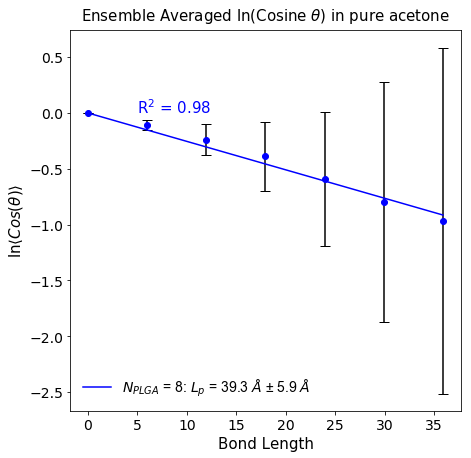

In [274]:
plt.figure(figsize=(7,7))
plt.errorbar(ace_ttn8, np.log(cor_n8ace_mat[0]), yerr=mk_n8ace, color='b', linestyle="None",marker='o',capsize=5, capthick=1, ecolor='black')
plt.plot(ttsam, slope_plen(ttsam, model_n8ace.coef_[0]), color='b')
plt.title(r'Ensemble Averaged ln(Cosine $\theta$) in pure acetone', fontsize=15, y=1.01)
plt.xlabel(r'Bond Length', fontsize=15)
plt.ylabel(r'ln$\left< Cos(\theta)\right >$', fontsize=15)
#plt.ylim(-1.9,0)
font = font_manager.FontProperties(family='Arial', style='normal', size='14')
plt.legend([r'$N_{PLGA}$ = 8: $L_{p}$ = 39.3 $\AA$ ± 5.9 $\AA$'], loc=3, frameon=0, fontsize=14, prop=font)
plt.tick_params(labelsize=14)
plt.text(5,0,r'R$^{2}$ = 0.98', fontsize=15, color='blue')

In [ ]:
def exfun(x, a):
    return np.exp(-x*lb_avg_n6ace/a)

nt = np.arange(7)
plt.scatter(nt, cor_n8ace_mat[0,:])
plt.plot(nt,exfun(nt, pers_n8ace))

## N = 10 acetone

In [275]:
n10_plga_ace = mda.Universe("n10_plga_50ns/1_xa_soln/confout.gro", "n10_plga_50ns/1_xa_soln/nopbc_n10ace.xtc")

In [276]:
n10_plga_ace

<Universe with 25153 atoms>

In [277]:
len(n10_plga_ace.trajectory)

5001

In [278]:
poly_n10_ace = n10_plga_ace.select_atoms("resname sPLG PLG tPLG and not type H")

In [279]:
com_bond_n10ace = np.zeros(shape=(1,5000))
count = 0
for ts in n10_plga_ace.trajectory[0:5000]:
    n10_mon1 = n10_plga_ace.select_atoms("resid 1")
    n10_mon2 = n10_plga_ace.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n10_mon1.center_of_mass(), n10_mon2.center_of_mass(), 
                                                   box=n10_plga_ace.trajectory.ts.dimensions)
    com_bond_n10ace[0, count] = oo_len
    count += 1
lb_avg_n10ace = np.mean(com_bond_n10ace)

In [280]:
lb_avg_n10ace

5.9959741164262175

In [ ]:
plt.scatter(np.arange(5000),com_bond_n6ace)
plt.scatter(np.arange(5000),com_bond_n8ace)
plt.scatter(np.arange(5000),com_bond_n10ace)

In [ ]:
n10_blks_ace = bavg_pers_cnt(5, poly_n10_ace, n10_plga_ace, lb_avg_n10ace, 0 , 5000)

In [ ]:
n10_blks_ace["Avg persistence length"]

In [ ]:
n10_blks_ace["Avg Radius of gyration"]

In [ ]:
np.mean(n10_blks_ace["Avg persistence length"])

In [ ]:
np.std(n10_blks_ace["Avg persistence length"])

In [ ]:
np.mean(n10_blks_ace["Avg Radius of gyration"])

In [ ]:
np.std(n10_blks_ace["Avg Radius of gyration"])

In [281]:
n10_rgens_ace, cor_n10ace_mat, N10aceens_cos, rg_avgn10ace = get_rg_pers_poly(poly_n10_ace, n10_plga_ace, 0, 5000, 
                                                                        lb_avg_n6ace)

In [282]:
cor_n10ace_mat

array([[1.00000000e+00, 8.87423200e-01, 7.58542532e-01, 6.51133256e-01,
        5.44373891e-01, 4.52844031e-01, 4.20489702e-01, 3.68561063e-01,
        3.05002711e-01],
       [4.35116786e-17, 3.72896349e-02, 9.05809996e-02, 1.40393990e-01,
        2.06063135e-01, 2.60090607e-01, 3.15658989e-01, 3.89937394e-01,
        5.04578358e-01],
       [0.00000000e+00, 2.70779481e+01, 3.99899855e+01, 4.84788315e+01,
        5.58602289e+01, 6.17415841e+01, 6.34287892e+01, 6.61911990e+01,
        6.96044751e+01],
       [1.00000000e+00, 2.00000000e+00, 3.00000000e+00, 4.00000000e+00,
        5.00000000e+00, 6.00000000e+00, 7.00000000e+00, 8.00000000e+00,
        9.00000000e+00]])

In [283]:
cor_n10ace_mat[0]

array([1.        , 0.8874232 , 0.75854253, 0.65113326, 0.54437389,
       0.45284403, 0.4204897 , 0.36856106, 0.30500271])

In [284]:
# x values
ace_ttn10 = np.arange(9, dtype=float)
ace_ttn10 *= lb_avg_n6ace
#nt_ttn20[0] = 0
ace_ttn10

array([ 0.        ,  5.98655114, 11.97310228, 17.95965343, 23.94620457,
       29.93275571, 35.91930685, 41.905858  , 47.89240914])

In [285]:
# Sample standard deviation of Bond Length x values 
np.sqrt((np.sum(ace_ttn10**2) - ((np.sum(ace_ttn10)**2)/9))/8)

16.39484551155856

In [286]:
# Sample variance of Bond Length x values 
n10sace_var = (np.sum(ace_ttn10**2) - ((np.sum(ace_ttn10)**2)/9))/8
n10sace_var

268.7909593478719

In [287]:
# y values
n10lc_ace = np.log(cor_n10ace_mat[0])
n10lc_ace

array([ 0.        , -0.1194333 , -0.27635641, -0.42904096, -0.60811897,
       -0.79220752, -0.86633529, -0.99814887, -1.18743461])

In [288]:
mk_n10ace = cor_n10ace_mat[1]/cor_n10ace_mat[0]

<ErrorbarContainer object of 3 artists>

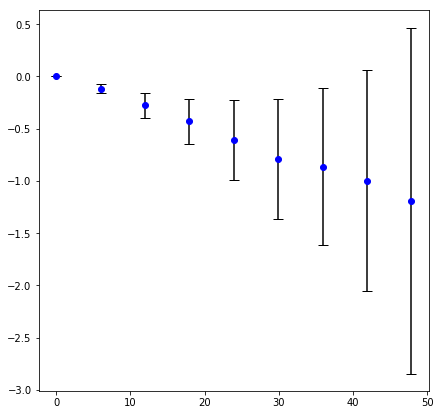

In [289]:
plt.figure(figsize=(7,7))
plt.errorbar(ace_ttn10, np.log(cor_n10ace_mat[0]), yerr=mk_n10ace, color='b', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')

In [290]:
from sklearn.linear_model import LinearRegression
model_n10ace = LinearRegression(fit_intercept=False)
model_n10ace.fit(ace_ttn10.reshape(-1,1), n10lc_ace)
# Slope here is in angstroms
print("Model slope:    ", model_n10ace.coef_)
print("Model intercept:", model_n10ace.intercept_)

Model slope:     [-0.02459542]
Model intercept: 0.0


In [291]:
gg_n10ace = model_n10ace.predict(ace_ttn10.reshape(-1,1))
gg_n10ace

array([ 0.        , -0.14724173, -0.29448346, -0.44172519, -0.58896693,
       -0.73620866, -0.88345039, -1.03069212, -1.17793385])

In [292]:
print("Mean Std Error:", sklearn.metrics.mean_squared_error(n10lc_ace, model_n10ace.predict(ace_ttn10.reshape(-1,1))))
print("R2 score:", sklearn.metrics.r2_score(n10lc_ace, model_n10ace.predict(ace_ttn10.reshape(-1,1))))

Mean Std Error: 0.0006897461779300974
R2 score: 0.9953492721815346


In [293]:
# Residuals between the true y data and model y data 
resid_n10ace = n10lc_ace - gg_n10ace
resid_n10ace

array([ 0.        ,  0.02780843,  0.01812705,  0.01268423, -0.01915204,
       -0.05599886,  0.0171151 ,  0.03254325, -0.00950076])

In [294]:
# How to calculate mean squared error
np.sum(resid_n10ace**2)/len(resid_n10ace)

0.0006897461779300974

In [295]:
# Standard error: Square root of the mean squared error 
np.sqrt(np.sum(resid_n10ace**2)/len(resid_n10ace))

0.026263019208196483

In [296]:
# sample variance of the residuals 
ntr_n10ace = resid_n10ace
ntr_n10ace -= np.mean(resid_n10ace)
nhr_n10ace = ntr_n10ace**2
np.sum(nhr_n10ace)/8

0.0007682115763573245

In [297]:
# How to calculate Sum((Xi - avg(X))^2): X values are the bond length values 
nt_n10ace = np.arange(9, dtype=float)
nt_n10ace *= lb_avg_n6ace
nt_n10ace -= np.mean(nt_n10ace)
nhui = nt_n10ace**2
np.sum(nhui)

2150.3276747829764

In [298]:
# How to calculate 95% confidence interval for the slope 
flc_n10ace = scipy.stats.t.ppf(0.975, 4)*np.sqrt((np.sum(resid_n10ace**2)/len(resid_n10ace))/(np.sum(nhui)))
flc_n10ace

0.0015645913737879107

In [299]:
pers_n10ace =-1/model_n10ace.coef_
pers_n10ace

array([40.65797843])

In [300]:
# Pers length error: error propagation from uncertainty in slope 
flc_n10ace/((model_n10ace.coef_)**2)

array([2.58638095])

In [301]:
def slope_plen(x,m):
    return m*x

ttsam = np.arange(9, dtype=float)
ttsam *= lb_avg_n6ace
#nt_ttn10[0] = 0
ttsam

array([ 0.        ,  5.98655114, 11.97310228, 17.95965343, 23.94620457,
       29.93275571, 35.91930685, 41.905858  , 47.89240914])

Text(5, 0, 'R$^{2}$ = 0.995')

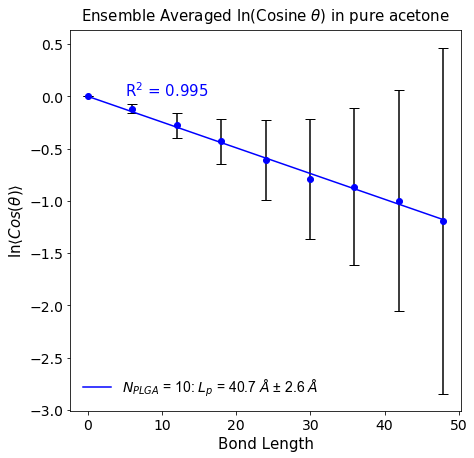

In [302]:
plt.figure(figsize=(7,7))
plt.errorbar(ace_ttn10, np.log(cor_n10ace_mat[0]), yerr=mk_n10ace, color='b',
             linestyle="None",marker='o',capsize=5, capthick=1, ecolor='black')
plt.plot(ttsam, slope_plen(ttsam, model_n10ace.coef_[0]), color='b')
plt.title(r'Ensemble Averaged ln(Cosine $\theta$) in pure acetone', fontsize=15, y=1.01)
plt.xlabel(r'Bond Length', fontsize=15)
plt.ylabel(r'ln$\left< Cos(\theta)\right >$', fontsize=15)
#plt.ylim(-1.9,0)
font = font_manager.FontProperties(family='Arial', style='normal', size='14')
plt.legend([r'$N_{PLGA}$ = 10: $L_{p}$ = 40.7 $\AA$ ± 2.6 $\AA$'], loc=3, frameon=0, fontsize=14, prop=font)
plt.tick_params(labelsize=14)
plt.text(5,0,r'R$^{2}$ = 0.995', fontsize=15, color='blue')

In [ ]:
def exfun(x, a):
    return np.exp(-x*lb_avg_n6ace/a)

nt = np.arange(9)
plt.scatter(nt, cor_n10ace_mat[0,:])
plt.plot(nt,exfun(nt, pers_n10ace))

## N = 20 acetone

In [303]:
n20_plga_ace = mda.Universe("n20_plga_150ns/1_xa_soln/1xa_n20sys.gro", "n20_plga_150ns/1_xa_soln/N20_nopbcpp_0xa.xtc")

In [304]:
n20_plga_ace

<Universe with 303 atoms>

In [305]:
len(n20_plga_ace.trajectory)

15001

In [306]:
poly_n20_ace = n20_plga_ace.select_atoms("resname sPLG PLG tPLG and not type H")

In [307]:
com_bond_n20ace = np.zeros(shape=(1,5000))
count = 0
for ts in n20_plga_ace.trajectory[0:5000]:
    n20_mon1 = n20_plga_ace.select_atoms("resid 1")
    n20_mon2 = n20_plga_ace.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n20_mon1.center_of_mass(), n20_mon2.center_of_mass(), 
                                                   box=n20_plga_ace.trajectory.ts.dimensions)
    com_bond_n20ace[0, count] = oo_len
    count += 1
lb_avg_n20ace = np.mean(com_bond_n20ace)

In [308]:
lb_avg_n20ace

5.932062741435674

In [ ]:
plt.scatter(np.arange(5000),com_bond_n6ace)
plt.scatter(np.arange(5000),com_bond_n8ace)
plt.scatter(np.arange(5000),com_bond_n10ace)
plt.scatter(np.arange(5000),com_bond_n20ace)

In [ ]:
n20_blks_ace = bavg_pers_cnt(5, poly_n20_ace, n20_plga_ace, lb_avg_n6ace, 0 , 15000)

In [ ]:
n20_blks_ace["Avg persistence length"]

In [ ]:
n20_blks_ace["Avg Radius of gyration"]

In [ ]:
np.mean(n20_blks_ace["Avg persistence length"])

In [ ]:
np.std(n20_blks_ace["Avg persistence length"])

In [ ]:
np.mean(n20_blks_ace["Avg Radius of gyration"])

In [ ]:
np.std(n20_blks_ace["Avg Radius of gyration"])

In [309]:
n20_rgens_ace, cor_n20ace_mat, N20aceens_cos, rg_avgn20ace = get_rg_pers_poly(poly_n20_ace, n20_plga_ace, 0, 15000, 
                                                                        lb_avg_n6ace)

In [310]:
cor_n20ace_mat

array([[1.00000000e+00, 8.93548713e-01, 7.66430404e-01, 6.57713003e-01,
        5.78363698e-01, 5.14835945e-01, 4.70472149e-01, 4.37114942e-01,
        4.13403297e-01, 3.88713887e-01, 3.71001974e-01, 3.53750173e-01,
        3.40811052e-01, 3.34340808e-01, 3.34014596e-01, 3.29686014e-01,
        3.15979708e-01, 2.84130624e-01, 2.79729000e-01],
       [2.35688259e-17, 2.60524980e-02, 6.60260008e-02, 9.45405337e-02,
        1.14402666e-01, 1.37225742e-01, 1.62299618e-01, 1.89020583e-01,
        2.11861264e-01, 2.29821323e-01, 2.54277855e-01, 2.88098505e-01,
        3.11961653e-01, 3.22486822e-01, 3.32966062e-01, 3.57790682e-01,
        4.18548636e-01, 4.84485938e-01, 5.54653822e-01],
       [0.00000000e+00, 2.64803380e+01, 3.95871554e+01, 4.84468715e+01,
        5.42249732e+01, 5.85279359e+01, 6.13718169e+01, 6.34172521e+01,
        6.48274731e+01, 6.63411829e+01, 6.73615667e+01, 6.82685267e+01,
        6.89568895e+01, 6.92663608e+01, 6.91179611e+01, 6.92025785e+01,
        6.96710424e+01

In [311]:
cor_n20ace_mat[0]

array([1.        , 0.89354871, 0.7664304 , 0.657713  , 0.5783637 ,
       0.51483595, 0.47047215, 0.43711494, 0.4134033 , 0.38871389,
       0.37100197, 0.35375017, 0.34081105, 0.33434081, 0.3340146 ,
       0.32968601, 0.31597971, 0.28413062, 0.279729  ])

In [312]:
# x values
ace_ttn20 = np.arange(19, dtype=float)
ace_ttn20 *= lb_avg_n6ace
#nt_ttn20[0] = 0
ace_ttn20

array([  0.        ,   5.98655114,  11.97310228,  17.95965343,
        23.94620457,  29.93275571,  35.91930685,  41.905858  ,
        47.89240914,  53.87896028,  59.86551142,  65.85206257,
        71.83861371,  77.82516485,  83.81171599,  89.79826713,
        95.78481828, 101.77136942, 107.75792056])

In [313]:
# Sample standard deviation of Bond Length x values 
np.sqrt((np.sum(ace_ttn20**2) - ((np.sum(ace_ttn20)**2)/19))/18)

33.688205082654896

In [314]:
# Sample variance of Bond Length x values 
n20sace_var = (np.sum(ace_ttn20**2) - ((np.sum(ace_ttn20)**2)/19))/18
n20sace_var

1134.8951616910153

In [315]:
# y values
n20lc_ace = np.log(cor_n20ace_mat[0])
n20lc_ace

array([ 0.        , -0.11255443, -0.26601138, -0.41898661, -0.54755237,
       -0.66390698, -0.75401852, -0.82755909, -0.88333166, -0.94491172,
       -0.9915479 , -1.03916434, -1.07642706, -1.09559442, -1.09657059,
       -1.10961455, -1.15207728, -1.2583212 , -1.273934  ])

In [316]:
mk_n20ace = cor_n20ace_mat[1]/cor_n20ace_mat[0]

<ErrorbarContainer object of 3 artists>

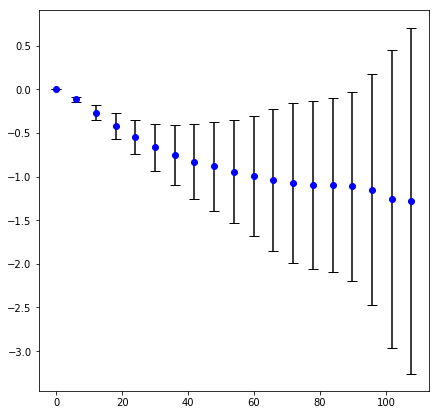

In [317]:
plt.figure(figsize=(7,7))
plt.errorbar(ace_ttn20, np.log(cor_n20ace_mat[0]), yerr=mk_n20ace, color='b', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')

In [318]:
ace_ttn20[:7]

array([ 0.        ,  5.98655114, 11.97310228, 17.95965343, 23.94620457,
       29.93275571, 35.91930685])

In [319]:
from sklearn.linear_model import LinearRegression
model_n20ace = LinearRegression(fit_intercept=False)
model_n20ace.fit(ace_ttn20[:7].reshape(-1,1), n20lc_ace[:7])
# Slope here is in angstroms
print("Model slope:    ", model_n20ace.coef_)
print("Model intercept:", model_n20ace.intercept_)

Model slope:     [-0.0219088]
Model intercept: 0.0


In [320]:
gg_n20ace = model_n20ace.predict(ace_ttn20.reshape(-1,1))
gg_n20ace

array([ 0.        , -0.13115816, -0.26231632, -0.39347448, -0.52463264,
       -0.6557908 , -0.78694896, -0.91810712, -1.04926528, -1.18042343,
       -1.31158159, -1.44273975, -1.57389791, -1.70505607, -1.83621423,
       -1.96737239, -2.09853055, -2.22968871, -2.36084687])

In [321]:
print("Mean Std Error:", sklearn.metrics.mean_squared_error(n20lc_ace[:7], 
                                                            model_n20ace.predict(ace_ttn20[:7].reshape(-1,1))))
print("R2 score:", sklearn.metrics.r2_score(n20lc_ace[:7],
                                            model_n20ace.predict(ace_ttn20[:7].reshape(-1,1))))

Mean Std Error: 0.0003837459779299569
R2 score: 0.9943742967646797


In [322]:
# Residuals between the true y data and model y data 
resid_n20ace = n20lc_ace[:7] - gg_n20ace[:7]
resid_n20ace

array([ 0.        ,  0.01860373, -0.00369506, -0.02551213, -0.02291974,
       -0.00811619,  0.03293044])

In [323]:
# How to calculate mean squared error
np.sum(resid_n20ace**2)/len(resid_n20ace)

0.0003837459779299569

In [324]:
# Standard error: Square root of the mean squared error 
np.sqrt(np.sum(resid_n20ace**2)/len(resid_n20ace))

0.01958943536526658

In [325]:
# sample variance of the residuals 
ntr_n20ace = resid_n20ace
ntr_n20ace -= np.mean(resid_n20ace)
nhr_n20ace = ntr_n20ace**2
np.sum(nhr_n20ace)/7

0.00038219810829775286

In [326]:
# How to calculate Sum((Xi - avg(X))^2): X values are the bond length values, I only used 7 points to fit data 
nt_n20ace = np.arange(7, dtype=float)
nt_n20ace *= lb_avg_n6ace
nt_n20ace -= np.mean(nt_n20ace)
nhui = nt_n20ace**2
np.sum(nhui)

1003.4862482320556

In [327]:
# How to calculate 95% confidence interval for the slope 
flc_n20ace = scipy.stats.t.ppf(0.975, 4)*np.sqrt((np.sum(resid_n20ace**2)/len(resid_n20ace))/(np.sum(nhui)))
flc_n20ace

0.0017134744980350038

In [328]:
pers_n20ace =-1/model_n20ace.coef_
pers_n20ace

array([45.64375688])

In [329]:
# Pers length error: error propagation from uncertainty in slope 
flc_n20ace/((model_n20ace.coef_)**2)

array([3.56977145])

In [330]:
def slope_plen(x,m):
    return m*x

ttsam = np.arange(19, dtype=float)
ttsam *= lb_avg_n6ace
#nt_ttn10[0] = 0
ttsam

array([  0.        ,   5.98655114,  11.97310228,  17.95965343,
        23.94620457,  29.93275571,  35.91930685,  41.905858  ,
        47.89240914,  53.87896028,  59.86551142,  65.85206257,
        71.83861371,  77.82516485,  83.81171599,  89.79826713,
        95.78481828, 101.77136942, 107.75792056])

Text(5, 0, 'R$^{2}$ = 0.994')

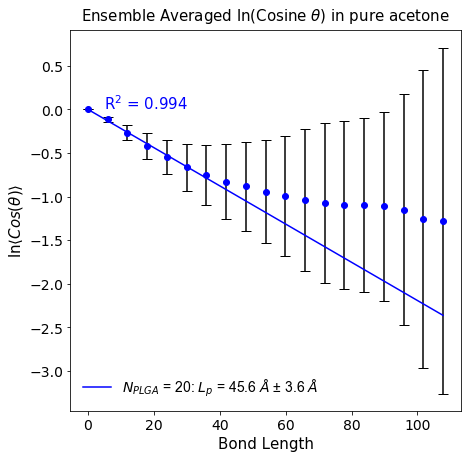

In [331]:
plt.figure(figsize=(7,7))
plt.errorbar(ace_ttn20, np.log(cor_n20ace_mat[0]), yerr=mk_n20ace, color='b',
             linestyle="None",marker='o',capsize=5, capthick=1, ecolor='black')
plt.plot(ttsam, slope_plen(ttsam, model_n20ace.coef_[0]), color='b')
plt.title(r'Ensemble Averaged ln(Cosine $\theta$) in pure acetone', fontsize=15, y=1.01)
plt.xlabel(r'Bond Length', fontsize=15)
plt.ylabel(r'ln$\left< Cos(\theta)\right >$', fontsize=15)
#plt.ylim(-1.9,0)
font = font_manager.FontProperties(family='Arial', style='normal', size='14')
plt.legend([r'$N_{PLGA}$ = 20: $L_{p}$ = 45.6 $\AA$ ± 3.6 $\AA$'], loc=3, frameon=0, fontsize=14, prop=font)
plt.tick_params(labelsize=14)
plt.text(5,0,r'R$^{2}$ = 0.994', fontsize=15, color='blue')

In [ ]:
def exfun(x, a):
    return np.exp(-x*lb_avg_n6ace/a)

nt = np.arange(19)
plt.scatter(nt, cor_n20ace_mat[0,:])
plt.plot(nt,exfun(nt, pers_n20ace))

## N = 30 acetone

In [332]:
n30_plga_ace = mda.Universe("n30_plga_150ns/1_xa_soln/1xa_n30sys.gro", "n30_plga_150ns/1_xa_soln/N30_nopbcpp_1xa.xtc")

In [333]:
n30_plga_ace

<Universe with 453 atoms>

In [334]:
len(n30_plga_ace.trajectory)

15001

In [335]:
poly_n30_ace = n30_plga_ace.select_atoms("resname sPLG PLG tPLG and not type H")

In [336]:
com_bond_n30ace = np.zeros(shape=(1,5000))
count = 0
for ts in n30_plga_ace.trajectory[0:5000]:
    n30_mon1 = n30_plga_ace.select_atoms("resid 1")
    n30_mon2 = n30_plga_ace.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n30_mon1.center_of_mass(), n30_mon2.center_of_mass(), 
                                                   box=n30_plga_ace.trajectory.ts.dimensions)
    com_bond_n30ace[0, count] = oo_len
    count += 1
lb_avg_n30ace = np.mean(com_bond_n30ace)

In [337]:
lb_avg_n30ace

6.011313163610001

In [ ]:
plt.scatter(np.arange(5000),com_bond_n6ace)
plt.scatter(np.arange(5000),com_bond_n8ace)
plt.scatter(np.arange(5000),com_bond_n10ace)
plt.scatter(np.arange(5000),com_bond_n20ace)
plt.scatter(np.arange(5000),com_bond_n30ace)

In [ ]:
n30_blks_ace = bavg_pers_cnt(5, poly_n30_ace, n30_plga_ace, lb_avg_n6ace, 0 , 15000)

In [ ]:
n30_blks_ace["Avg persistence length"]

In [ ]:
n30_blks_ace["Avg Radius of gyration"]

In [ ]:
np.mean(n30_blks_ace["Avg persistence length"])

In [ ]:
np.std(n30_blks_ace["Avg persistence length"])

In [ ]:
np.mean(n30_blks_ace["Avg Radius of gyration"])

In [ ]:
np.std(n30_blks_ace["Avg Radius of gyration"])

In [338]:
n30_rgens_ace, cor_n30ace_mat, N30aceens_cos, rg_avgn30ace = get_rg_pers_poly(poly_n30_ace, n30_plga_ace, 0, 15000, 
                                                                        lb_avg_n6ace)

In [339]:
cor_n30ace_mat

array([[1.00000000e+00, 8.71294010e-01, 7.06134976e-01, 5.99381586e-01,
        5.35586775e-01, 4.73549814e-01, 4.17991967e-01, 3.80873979e-01,
        3.44249905e-01, 3.09969570e-01, 2.85057193e-01, 2.73219755e-01,
        2.66372457e-01, 2.49442172e-01, 2.34858882e-01, 2.20610138e-01,
        2.14438998e-01, 2.05682755e-01, 1.98806945e-01, 2.00681999e-01,
        2.26712522e-01, 2.42520121e-01, 2.39386469e-01, 2.35735962e-01,
        2.43340634e-01, 2.48875166e-01, 2.50217081e-01, 2.54867572e-01,
        2.51094145e-01],
       [2.71947991e-18, 2.67446250e-02, 6.67421245e-02, 7.85449267e-02,
        8.65089197e-02, 9.56257687e-02, 1.06346496e-01, 1.23825901e-01,
        1.29451685e-01, 1.33242677e-01, 1.43575210e-01, 1.62935701e-01,
        1.83308308e-01, 2.07934303e-01, 2.29477630e-01, 2.46889997e-01,
        2.60740099e-01, 2.77089357e-01, 2.96000748e-01, 3.05038316e-01,
        3.04161746e-01, 3.11958901e-01, 3.20116525e-01, 3.30260473e-01,
        3.55755605e-01, 3.84048645e-01,

In [340]:
cor_n30ace_mat[0]

array([1.        , 0.87129401, 0.70613498, 0.59938159, 0.53558677,
       0.47354981, 0.41799197, 0.38087398, 0.3442499 , 0.30996957,
       0.28505719, 0.27321975, 0.26637246, 0.24944217, 0.23485888,
       0.22061014, 0.214439  , 0.20568275, 0.19880694, 0.200682  ,
       0.22671252, 0.24252012, 0.23938647, 0.23573596, 0.24334063,
       0.24887517, 0.25021708, 0.25486757, 0.25109415])

In [341]:
# x values
ace_ttn30 = np.arange(29, dtype=float)
ace_ttn30 *= lb_avg_n6ace
#nt_ttn20[0] = 0
ace_ttn30

array([  0.        ,   5.98655114,  11.97310228,  17.95965343,
        23.94620457,  29.93275571,  35.91930685,  41.905858  ,
        47.89240914,  53.87896028,  59.86551142,  65.85206257,
        71.83861371,  77.82516485,  83.81171599,  89.79826713,
        95.78481828, 101.77136942, 107.75792056, 113.7444717 ,
       119.73102285, 125.71757399, 131.70412513, 137.69067627,
       143.67722742, 149.66377856, 155.6503297 , 161.63688084,
       167.62343199])

In [342]:
# Sample standard deviation of Bond Length x values 
np.sqrt((np.sum(ace_ttn30**2) - ((np.sum(ace_ttn30)**2)/29))/28)

50.97364620104615

In [343]:
# Sample variance of Bond Length x values 
n30sace_var = (np.sum(ace_ttn30**2) - ((np.sum(ace_ttn30)**2)/29))/28
n30sace_var

2598.312607029427

In [344]:
# y values
n30lc_ace = np.log(cor_n30ace_mat[0])
n30lc_ace

array([ 0.        , -0.1377758 , -0.34794888, -0.51185685, -0.62439236,
       -0.74749817, -0.87229306, -0.96528672, -1.06638742, -1.17128115,
       -1.25506544, -1.29747885, -1.32285973, -1.38852817, -1.44877045,
       -1.51135822, -1.53972997, -1.58142032, -1.61542105, -1.60603372,
       -1.48407249, -1.4166706 , -1.42967601, -1.4450429 , -1.41329303,
       -1.39080385, -1.38542641, -1.36701119, -1.38192733])

In [345]:
mk_n30ace = cor_n30ace_mat[1]/cor_n30ace_mat[0]

<ErrorbarContainer object of 3 artists>

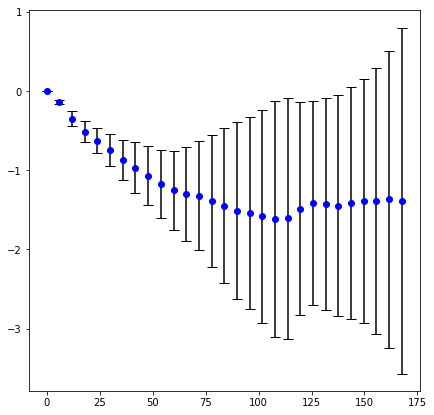

In [346]:
plt.figure(figsize=(7,7))
plt.errorbar(ace_ttn30, np.log(cor_n30ace_mat[0]), yerr=mk_n30ace, color='b', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')

In [347]:
ace_ttn30[:8]

array([ 0.        ,  5.98655114, 11.97310228, 17.95965343, 23.94620457,
       29.93275571, 35.91930685, 41.905858  ])

In [348]:
from sklearn.linear_model import LinearRegression
model_n30ace = LinearRegression(fit_intercept=False)
model_n30ace.fit(ace_ttn30[:7].reshape(-1,1), n30lc_ace[:7])
# Slope here is in angstroms
print("Model slope:    ", model_n30ace.coef_)
print("Model intercept:", model_n30ace.intercept_)

Model slope:     [-0.02540137]
Model intercept: 0.0


In [349]:
gg_n30ace = model_n30ace.predict(ace_ttn30.reshape(-1,1))
gg_n30ace

array([ 0.        , -0.15206662, -0.30413325, -0.45619987, -0.60826649,
       -0.76033312, -0.91239974, -1.06446636, -1.21653299, -1.36859961,
       -1.52066624, -1.67273286, -1.82479948, -1.97686611, -2.12893273,
       -2.28099935, -2.43306598, -2.5851326 , -2.73719922, -2.88926585,
       -3.04133247, -3.19339909, -3.34546572, -3.49753234, -3.64959897,
       -3.80166559, -3.95373221, -4.10579884, -4.25786546])

In [350]:
print("Mean Std Error:", sklearn.metrics.mean_squared_error(n30lc_ace[:7],
                                                            model_n30ace.predict(ace_ttn30[:7].reshape(-1,1))))
print("R2 score:", sklearn.metrics.r2_score(n30lc_ace[:7], 
                                            model_n30ace.predict(ace_ttn30[:7].reshape(-1,1))))

Mean Std Error: 0.0010364372453502374
R2 score: 0.9881117385436515


In [351]:
# Residuals between the true y data and model y data 
resid_n30ace = n30lc_ace[:7] - gg_n30ace[:7]
resid_n30ace

array([ 0.        ,  0.01429082, -0.04381563, -0.05565697, -0.01612586,
        0.01283495,  0.04010668])

In [352]:
# How to calculate mean squared error
np.sum(resid_n30ace**2)/len(resid_n30ace)

0.0010364372453502374

In [353]:
# Standard error: Square root of the mean squared error 
np.sqrt(np.sum(resid_n30ace**2)/len(resid_n30ace))

0.03219374543836485

In [354]:
# sample variance of the residuals 
ntr_n30ace = resid_n30ace
ntr_n30ace -= np.mean(resid_n30ace)
nhr_n30ace = ntr_n30ace**2
# divide by n-1 samples used to fit 
np.sum(nhr_n30ace)/6

0.0011534798359988483

In [355]:
# How to calculate Sum((Xi - avg(X))^2): X values are the bond length values 
nt_n30ace = np.arange(7, dtype=float)
nt_n30ace *= lb_avg_n6ace
nt_n30ace -= np.mean(nt_n30ace)
nhui = nt_n30ace**2
np.sum(nhui)

1003.4862482320556

In [356]:
# How to calculate 95% confidence interval for the slope 
flc_n30ace = scipy.stats.t.ppf(0.975, 4)*np.sqrt((np.sum(resid_n30ace**2)/len(resid_n30ace))/(np.sum(nhui)))
flc_n30ace

0.0027559097243471534

In [357]:
pers_n30ace =-1/model_n30ace.coef_
pers_n30ace

array([39.3679494])

In [358]:
# Pers length error: error propagation from uncertainty in slope 
flc_n30ace/((model_n30ace.coef_)**2)

array([4.27120656])

In [359]:
def slope_plen(x,m):
    return m*x

ttsam = np.arange(19, dtype=float)
ttsam *= lb_avg_n6ace
#nt_ttn10[0] = 0
ttsam

array([  0.        ,   5.98655114,  11.97310228,  17.95965343,
        23.94620457,  29.93275571,  35.91930685,  41.905858  ,
        47.89240914,  53.87896028,  59.86551142,  65.85206257,
        71.83861371,  77.82516485,  83.81171599,  89.79826713,
        95.78481828, 101.77136942, 107.75792056])

Text(5, 0, 'R$^{2}$ = 0.99')

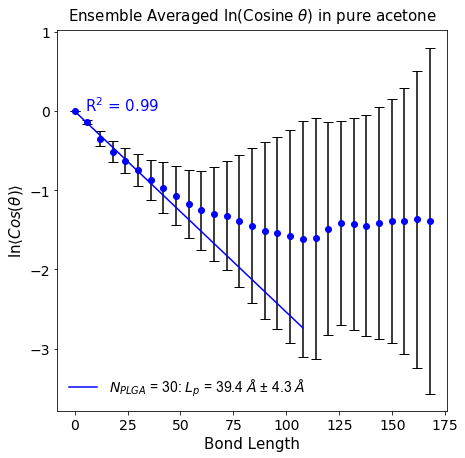

In [360]:
plt.figure(figsize=(7,7))
plt.errorbar(ace_ttn30, np.log(cor_n30ace_mat[0]), yerr=mk_n30ace, color='b',
             linestyle="None",marker='o',capsize=5, capthick=1, ecolor='black')
plt.plot(ttsam, slope_plen(ttsam, model_n30ace.coef_[0]), color='b')
plt.title(r'Ensemble Averaged ln(Cosine $\theta$) in pure acetone', fontsize=15, y=1.01)
plt.xlabel(r'Bond Length', fontsize=15)
plt.ylabel(r'ln$\left< Cos(\theta)\right >$', fontsize=15)
#plt.ylim(-1.9,0)
font = font_manager.FontProperties(family='Arial', style='normal', size='14')
plt.legend([r'$N_{PLGA}$ = 30: $L_{p}$ = 39.4 $\AA$ ± 4.3 $\AA$'], loc=3, frameon=0, fontsize=14, prop=font)
plt.tick_params(labelsize=14)
plt.text(5,0,r'R$^{2}$ = 0.99', fontsize=15, color='blue')

Text(1, -3.85, '$N_{PLGA}$ = 6: $L_{p}$ = 41.6 $\\AA$ ± 5.7 $\\AA$, R$^{2}$ = 0.99')

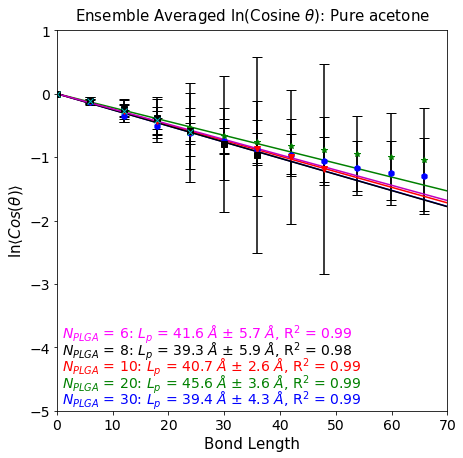

In [361]:
plt.figure(figsize=(7,7))
plt.errorbar(ace_ttn30, np.log(cor_n30ace_mat[0]), yerr=mk_n30ace, color='b', linestyle="None",marker='h',
     capsize=5, capthick=1, ecolor='black')
plt.plot(ttsam, slope_plen(ttsam, model_n30ace.coef_[0]), color='b')
plt.errorbar(ace_ttn20, np.log(cor_n20ace_mat[0]), yerr=mk_n20ace, color='g', linestyle="None"
             ,marker='*',capsize=5, capthick=1, ecolor='black')
plt.plot(ttsam, slope_plen(ttsam, model_n20ace.coef_[0]), color='g')
plt.errorbar(ace_ttn10, np.log(cor_n10ace_mat[0]), yerr=mk_n10ace, color='r', linestyle="None"
             ,marker='v', capsize=5, capthick=1, ecolor='black')
plt.plot(ttsam, slope_plen(ttsam, model_n10ace.coef_[0]), color='r')
plt.errorbar(ace_ttn8, np.log(cor_n8ace_mat[0]), yerr=mk_n8ace, color='k', linestyle="None",marker='s',
     capsize=5, capthick=1, ecolor='black')
plt.plot(ttsam, slope_plen(ttsam, model_n8ace.coef_[0]), color='k')
plt.errorbar(ace_ttn6, np.log(cor_n6ace_mat[0]), yerr=mk_n6ace, color='c', linestyle="None",marker='x',
     capsize=5, capthick=1, ecolor='black')
plt.plot(ttsam, slope_plen(ttsam, model_n6ace.coef_[0]), color='m')
plt.title(r'Ensemble Averaged ln(Cosine $\theta$): Pure acetone', fontsize=15, y=1.01)
plt.xlabel(r'Bond Length', fontsize=15)
plt.ylabel(r'ln$\left< Cos(\theta)\right >$', fontsize=15)
plt.ylim(-5, 1)
plt.xlim(0,70)
font = font_manager.FontProperties(family='Arial', style='normal', size='14')
#plt.legend([r'$N_{PLGA}$ = 30: $L_{p}$ = 18.5 $\AA$ ± 0.15 $\AA$,  R$^{2}$ = 0.99', r'$N_{PLGA}$ = 20: $L_{p}$ = 19.1 $\AA$ ± 0.27 $\AA$,  R$^{2}$ = 0.99'], 
#           loc=3, frameon=0, fontsize=14, prop=font)
#plt.legend([r'$N_{PLGA}$ = 20: $L_{p}$ = 19.1 $\AA$ ± 0.27 $\AA$,  R$^{2}$ = 0.99'], loc=3, frameon=0, fontsize=14, prop=font)
plt.tick_params(labelsize=14)
plt.text(1, -4.9,r'$N_{PLGA}$ = 30: $L_{p}$ = 39.4 $\AA$ ± 4.3 $\AA$, R$^{2}$ = 0.99', fontsize=14, color='blue')
plt.text(1,-4.65,r'$N_{PLGA}$ = 20: $L_{p}$ = 45.6 $\AA$ ± 3.6 $\AA$, R$^{2}$ = 0.99', fontsize=14, color='green')
plt.text(1,-4.38,r'$N_{PLGA}$ = 10: $L_{p}$ = 40.7 $\AA$ ± 2.6 $\AA$, R$^{2}$ = 0.99', fontsize=14, color='red')
plt.text(1,-4.12,r'$N_{PLGA}$ = 8: $L_{p}$ = 39.3 $\AA$ ± 5.9 $\AA$, R$^{2}$ = 0.98', fontsize=14, color='black')
plt.text(1,-3.85,r'$N_{PLGA}$ = 6: $L_{p}$ = 41.6 $\AA$ ± 5.7 $\AA$, R$^{2}$ = 0.99', fontsize=14, color='magenta')
#plt.text(2.5,0,r'R$^{2}$ = 0.96', fontsize=15, color='red')

In [ ]:
def exfun(x, a):
    return np.exp(-x*lb_avg_n6ace/a)

nt = np.arange(29)
plt.scatter(nt, cor_n30ace_mat[0,:])
plt.plot(nt,exfun(nt, pers_n30ace))